# Safe Withdrawal Rate Analysis: MSCI Europe 90% + Bund 10Y 10% (No Tax)

## Overview

This notebook performs a **Monte Carlo simulation** using **block bootstrap** methodology to analyze the **Safe Withdrawal Rate (SWR)** for a portfolio composed of:
- **90% MSCI Europe Index (Net Total Return)** (European equities)
- **10% German Bund 10Y** (government bonds)

> ⚠️ **Tax Assumption**: This simulation assumes **no capital gains tax** is applied on withdrawals. This represents an idealized scenario (e.g., tax-advantaged accounts, jurisdictions with no capital gains tax, or assets held beyond tax-exemption thresholds). For a realistic analysis in taxed environments, withdrawal amounts should be grossed up to account for applicable taxes.

## Methodology

### Block Bootstrap Approach
Unlike traditional Monte Carlo simulations that assume independent returns, the **block bootstrap** preserves the temporal structure and correlations in financial data by:
1. Sampling **consecutive blocks** of historical data (default: 6 months)
2. Randomly concatenating these blocks to create simulated future scenarios
3. Maintaining serial correlation and regime persistence

### Key Features
- **Historical data**: Daily returns from 2000-2025 (MSCI Europe) and 1997-2025 (Bund)
- **Inflation adjustment**: Withdrawals adjusted using Euro area HICP inflation
- **Calendar days**: All calculations use 365 days/year (not trading days)
- **100,000 simulations**: Provides robust statistical estimates
- **30-year horizon**: Standard retirement planning period
- **No capital gains tax**: Withdrawals are not subject to any taxation

### What This Analysis Provides
1. **Success rate**: Probability that portfolio survives 30 years
2. **Portfolio evolution**: Percentile bands (5th, 25th, 50th, 75th, 95th)
3. **Sensitivity analysis**: Impact of different withdrawal rates (2%-5%)
4. **Failure analysis**: Distribution of depletion years for failed scenarios

### Data Sources
- **Equities**: MSCI Europe Net Total Return Index (EUR) - includes reinvested dividends net of withholding taxes
- **Bonds**: German Bund 10Y yields (converted to returns)
- **Inflation**: Eurostat HICP for Euro area

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime
from joblib import Parallel, delayed

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

---

## 1. Data Loading Functions

These functions load historical price data for:
- **Equity indices**: MSCI World, MSCI ACWI, MSCI Italy, MSCI Europe, MSCI EMU, STOXX Europe 600
- **Bond yields**: BTP 10Y (Italy), Bund 10Y (Germany), OAT 10Y (France)
- **Inflation**: ISTAT FOI (Italy), Eurostat HICP (Italy & Euro area)

> **Note on MSCI indices**: All MSCI indices used are **Net Total Return** versions, which include reinvested dividends after deducting withholding taxes applicable to non-resident investors.

In [2]:
def load_asset_data(base_path: Path) -> Dict[str, pd.DataFrame]:
    """
    Load all asset data from CSV files.
    
    Returns:
        Dictionary with asset names as keys and DataFrames as values
    """
    assets = {}
    
    # MSCI indices
    msci_files = {
        'MSCI_WORLD': 'data/msci/WORLD.csv',
        'MSCI_ACWI': 'data/msci/ACWI.csv',
        'MSCI_ITALY': 'data/msci/ITALY.csv',
        'MSCI_EUROPE': 'data/msci/EUROPE.csv',
        'MSCI_EMU': 'data/msci/EMU.csv'
    }
    
    for name, path in msci_files.items():
        df = pd.read_csv(base_path / path)
        df.columns = ['date', 'price']
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        assets[name] = df
    
    # STOXX
    df_stoxx = pd.read_csv(base_path / 'data/stoxx/STOXX_SXXGR_DAILY.csv')
    df_stoxx.columns = ['date', 'price']
    df_stoxx['date'] = pd.to_datetime(df_stoxx['date'])
    df_stoxx = df_stoxx.sort_values('date')
    assets['STOXX_SXXGR'] = df_stoxx
    
    # BTP 10Y (Italian bonds)
    df_btp = pd.read_csv(base_path / 'data/bdi/BMK0200/MFN_BMK.D.020.922.0.EUR.210.csv')
    df_btp.columns = ['date', 'yield']
    df_btp['date'] = pd.to_datetime(df_btp['date'])
    df_btp = df_btp.sort_values('date')
    assets['BTP_10Y'] = df_btp
    
    # Bund 10Y (German bonds)
    df_bund = pd.read_csv(base_path / 'data/bund/bbsis/BBSIS_10_YEARS_YIELDS.csv')
    df_bund.columns = ['date', 'yield']
    df_bund['date'] = pd.to_datetime(df_bund['date'])
    df_bund = df_bund.sort_values('date')
    assets['BUND_10Y'] = df_bund
    
    # OAT 10Y (French bonds)
    df_oat = pd.read_csv(base_path / 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS_MERGED_FR10.csv')
    df_oat.columns = ['date', 'yield']
    df_oat['date'] = pd.to_datetime(df_oat['date'])
    df_oat = df_oat.sort_values('date')
    assets['OAT_10Y'] = df_oat
    
    return assets


def load_inflation_data(base_path: Path) -> Dict[str, pd.DataFrame]:
    """
    Load inflation data from CSV files.
    
    Returns:
        Dictionary with inflation series names as keys and DataFrames as values
    """
    inflation = {}
    
    # ISTAT FOI (Italy)
    df_foi = pd.read_csv(base_path / 'data/istat/FOI_MONTHLY.csv')
    df_foi.columns = ['date', 'value', 'base']
    df_foi['date'] = pd.to_datetime(df_foi['date'])
    df_foi = df_foi.sort_values('date')
    inflation['FOI_IT'] = df_foi[['date', 'value']]
    
    # Eurostat HICP
    df_hicp = pd.read_csv(base_path / 'data/eurostat/hicp_it_eu.csv')
    df_hicp['TIME_PERIOD'] = pd.to_datetime(df_hicp['TIME_PERIOD'])
    
    # Filter for Italy and EU
    df_hicp_it = df_hicp[df_hicp['geo'] == 'Italy'][['TIME_PERIOD', 'OBS_VALUE']].copy()
    df_hicp_it.columns = ['date', 'value']
    df_hicp_it = df_hicp_it.sort_values('date')
    inflation['HICP_IT'] = df_hicp_it
    
    df_hicp_eu = df_hicp[df_hicp['geo'] == 'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)'][['TIME_PERIOD', 'OBS_VALUE']].copy()
    df_hicp_eu.columns = ['date', 'value']
    df_hicp_eu = df_hicp_eu.sort_values('date')
    inflation['HICP_EU'] = df_hicp_eu
    
    return inflation

## 2. Data Preparation Functions

### Return Calculations
- **Equity returns**: Log returns calculated as `ln(P_t / P_{t-1})`
- **Bond returns**: 
  - **Total return approximation**: `yield_t/365 - duration × Δyield_t` (simple return)
  - **Then converted to log return**: `ln(1 + simple_return)`
  - Captures both income (yield) and capital gain/loss (duration × yield change)
  - Uses modified duration ≈ 8.0 for 10Y bonds
- **Inflation**: Log returns calculated as `ln(CPI_t / CPI_{t-1})`

### Consistency Note
All returns are expressed as LOG RETURNS. This ensures:
1. Correct weighted averaging for portfolio returns
2. Correct compounding via `exp(sum(log_returns)) - 1`
3. Mathematical consistency across all asset classes

### Bond Total Return Model
The total return of a bond consists of two components:
1. **Income return**: The yield earned over the holding period (`yield / 365` per day)
2. **Price return**: Capital gain/loss due to yield changes (`-duration × Δyield`)

This is a **linear approximation** valid for small yield changes. Limitations:
- Ignores convexity (second-order effects)
- Assumes constant duration (actual duration changes with yield levels)
- For higher precision, use official total return indices

### Key Notes
- All data uses **calendar days** (365 days/year), not trading days (252 days/year)
- Monthly inflation is divided by actual days in month for precision
- Forward-fill is used to handle missing data (weekends, holidays)
- All returns (equity, bond, inflation) use log returns for consistent compounding via `exp(sum(log_returns)) - 1`

In [3]:
def calculate_daily_returns(df: pd.DataFrame, price_col: str = 'price') -> pd.DataFrame:
    """
    Calculate daily log returns from price data.
    """
    df = df.copy()
    df['return'] = np.log(df[price_col] / df[price_col].shift(1))
    return df.dropna()


def calculate_bond_returns_income_only(df: pd.DataFrame, yield_col: str = 'yield') -> pd.DataFrame:
    """
    Calculate daily returns from bond yields using INCOME ONLY (old method).
    
    This method is DEPRECATED - it ignores capital gains/losses from yield changes.
    Kept for comparison purposes.
    
    Daily return ≈ yield/365 (income return only)
    
    WARNING: This significantly underestimates volatility and misses capital
    gains during falling rate environments and capital losses during rising rates.
    """
    df = df.copy()
    df['return'] = df[yield_col] / 100 / 365  # Simple daily yield return (calendar days)
    return df


def calculate_bond_total_returns(
    df: pd.DataFrame,
    yield_col: str = 'yield',
    duration: float = 8.0,
    yield_in_percent: bool = True
) -> pd.DataFrame:
    """
    Calculate daily TOTAL returns from bond yields using duration approximation.
    
    Returns LOG RETURNS for consistency with equity calculations and 
    the simulation's compounding method: exp(sum(log_returns)) - 1
    
    Total Return (simple) ≈ (yield_t / 365) - duration × Δyield_t
    Then converted to log return: ln(1 + simple_return)
    
    This captures both:
    1. Income return: yield earned over the holding period
    2. Price return: capital gain/loss due to yield changes (via duration)
    
    Args:
        df: DataFrame with date and yield columns
        yield_col: Name of the yield column
        duration: Modified duration of the bond (default 8.0 for 10Y bonds)
        yield_in_percent: True if yields are in percent format (e.g., 2.5 for 2.5%)
                         False if yields are in decimal format (e.g., 0.025 for 2.5%)
    
    Returns:
        DataFrame with 'date' and 'return' columns (LOG RETURNS, first row dropped due to diff)
    
    Notes:
        - This is a LINEAR APPROXIMATION valid for small yield changes
        - Ignores convexity (second-order effects on price)
        - Assumes constant duration (actual duration varies with yield level)
        - For higher precision, use official total return indices (e.g., Bloomberg indices)
        - Modified duration for a 10Y bond is typically 7-9 depending on coupon and yield
    
    Example:
        If yield drops from 2.5% to 2.4% (Δyield = -0.001 or -10 bps):
        - Income return: 0.025 / 365 ≈ 0.0068% per day
        - Price return: -8.0 × (-0.001) = +0.8%
        - Total simple return ≈ +0.81% for that day
        - Log return: ln(1 + 0.0081) ≈ 0.0081
    """
    df = df.copy()
    
    # Convert yield to decimal if in percent format
    if yield_in_percent:
        yield_decimal = df[yield_col] / 100
    else:
        yield_decimal = df[yield_col]
    
    # Calculate yield change (Δyield)
    yield_change = yield_decimal.diff()
    
    # Calculate total return components (as simple returns)
    income_return = yield_decimal / 365
    price_return = -duration * yield_change
    simple_return = income_return + price_return
    
    # Convert to LOG RETURN for consistency with equity returns
    # Add floor to handle extreme negative returns (prevents log of negative number)
    # Floor at -99.9% simple return (very conservative, allows for extreme but realistic scenarios)
    simple_return_floored = np.maximum(simple_return, -0.999)
    df['return'] = np.log(1 + simple_return_floored)
    
    # Drop first row (NaN from diff) and any other missing values
    df = df.dropna(subset=['return'])
    df = df[['date', 'return']].copy()
    
    return df


# Legacy alias for backward compatibility (points to old income-only method)
calculate_bond_returns = calculate_bond_returns_income_only


def calculate_inflation_rate(df: pd.DataFrame, value_col: str = 'value') -> pd.DataFrame:
    """
    Calculate monthly inflation rate from price index using LOG RETURNS.
    
    Using log returns ensures consistency with:
    - Equity return calculations (also log returns)
    - The compounding method in simulations: exp(sum(log_returns)) - 1
    
    Args:
        df: DataFrame with date and price index columns
        value_col: Name of the price index column
    
    Returns:
        DataFrame with 'date' and 'inflation' columns (log returns)
    """
    df = df.copy()
    df['inflation'] = np.log(df[value_col] / df[value_col].shift(1))
    return df.dropna()


def merge_to_common_dates(assets_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Merge all asset returns to common dates.
    """
    merged = None
    
    for name, df in assets_dict.items():
        df_temp = df[['date', 'return']].copy()
        df_temp.columns = ['date', name]
        
        if merged is None:
            merged = df_temp
        else:
            merged = pd.merge(merged, df_temp, on='date', how='outer')
    
    merged = merged.sort_values('date')
    return merged

def calculate_portfolio_log_return(
    returns_df: pd.DataFrame,
    weights: Dict[str, float]
) -> pd.Series:
    """
    Calculate portfolio log return from individual asset log returns.
    
    Log returns are NOT additive cross-sectionally (across assets).
    They are only additive temporally (same asset over time).
    
    Correct formula: r_portfolio = ln(sum(w_i * exp(r_i)))
    
    This converts log returns to growth factors, takes weighted average,
    then converts back to log return.
    
    Args:
        returns_df: DataFrame with columns for each asset (log returns)
        weights: Dictionary {asset_name: weight} where weights sum to 1
        
    Returns:
        Series with portfolio log returns
    """
    # Calculate weighted sum of growth factors: sum(w_i * exp(r_i))
    weighted_growth = sum(
        weights[asset] * np.exp(returns_df[asset])
        for asset in weights.keys()
    )
    
    # Convert back to log return
    return np.log(weighted_growth)

def upsample_inflation_to_daily(inflation_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Convert monthly inflation to daily by dividing by days in month.
    """
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    daily_df = pd.DataFrame({'date': daily_dates})
    
    # Create year-month column for merging
    daily_df['year_month'] = daily_df['date'].dt.to_period('M')
    daily_df['days_in_month'] = daily_df['date'].dt.days_in_month
    
    inflation_df = inflation_df.copy()
    inflation_df['year_month'] = inflation_df['date'].dt.to_period('M')
    
    # Merge
    merged = pd.merge(daily_df, inflation_df[['year_month', 'inflation']], 
                      on='year_month', how='left')
    
    # Convert monthly to daily (divide by actual days in month)
    merged['daily_inflation'] = merged['inflation'] / merged['days_in_month']
    merged = merged[['date', 'daily_inflation']]
    merged.columns = ['date', 'inflation']
    
    return merged

---

## 3. Block Bootstrap Implementation

### Why Block Bootstrap?
Financial returns exhibit:
- **Volatility clustering**: High/low volatility periods persist
- **Serial correlation**: Today's return affects tomorrow's
- **Market regimes**: Bull/bear markets last for extended periods

### How It Works
1. Divide historical data into overlapping blocks (default: 6 months = ~180 days)
2. Randomly sample blocks with replacement
3. Concatenate to create 30 years (10,950 days) of simulated returns
4. Preserve within-block correlations and patterns

### Block Size Parameter
- **Smaller blocks** (1-3 months): More independent, less structure preservation
- **Larger blocks** (6-12 months): Better structure preservation, less variation
- **Default**: 6 months balances both objectives

In [4]:
def block_bootstrap_sample(
    data: pd.DataFrame,
    block_size_months: int = 6,
    n_years: int = 30,
    rng: np.random.Generator = None
) -> pd.DataFrame:
    """
    Generate a block bootstrap sample from historical data.
    
    Args:
        data: DataFrame with date index and return columns
        block_size_months: Size of each block in months
        n_years: Number of years to generate
        rng: numpy random Generator for reproducibility (optional)
    
    Returns:
        DataFrame with bootstrapped returns
    """
    if rng is None:
        rng = np.random.default_rng()
    
    block_size_days = block_size_months * 30  # Approximate calendar days per month
    n_days_needed = n_years * 365  # Calendar days per year
    
    # Adjust block size if data is not long enough
    max_block_size = len(data) - 1
    if block_size_days > max_block_size:
        original_block_size = block_size_days
        block_size_days = max(30, max_block_size // 2)  # At least 1 month
        print(f"  Warning: Reducing block size from {original_block_size} to {block_size_days} days due to limited data")
    
    n_blocks_needed = int(np.ceil(n_days_needed / block_size_days))
    
    # Ensure we have enough data
    n_possible_blocks = len(data) - block_size_days + 1
    
    if n_possible_blocks < 1:
        raise ValueError(
            f"Not enough data for block size {block_size_days} days. "
            f"Available data: {len(data)} days. "
            f"Need at least {block_size_days} days."
        )
    
    # Randomly select block start positions using the provided RNG
    block_starts = rng.integers(0, n_possible_blocks, size=n_blocks_needed)
    
    # Concatenate blocks
    samples = []
    for start in block_starts:
        block = data.iloc[start:start + block_size_days].copy()
        samples.append(block)
    
    result = pd.concat(samples, ignore_index=True)
    
    # Trim to exact length needed
    result = result.iloc[:n_days_needed]
    
    # Reset index to be sequential days
    result = result.reset_index(drop=True)
    
    return result

---

## 4. Load Historical Data

Loading all available asset classes and inflation data from CSV files.

In [5]:
# Set base path
BASE_PATH = Path('..')

# Load data
print("Loading asset data...")
assets = load_asset_data(BASE_PATH)

print("Loading inflation data...")
inflation_data = load_inflation_data(BASE_PATH)

# Show available assets
print("\nAvailable assets:")
for name, df in assets.items():
    print(f"  {name}: {len(df)} observations from {df['date'].min()} to {df['date'].max()}")

print("\nAvailable inflation series:")
for name, df in inflation_data.items():
    print(f"  {name}: {len(df)} observations from {df['date'].min()} to {df['date'].max()}")

Loading asset data...
Loading inflation data...

Available assets:
  MSCI_WORLD: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  MSCI_ACWI: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  MSCI_ITALY: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  MSCI_EUROPE: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  MSCI_EMU: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  STOXX_SXXGR: 9991 observations from 1986-12-31 00:00:00 to 2025-12-12 00:00:00
  BTP_10Y: 11263 observations from 1994-12-31 00:00:00 to 2025-10-31 00:00:00
  BUND_10Y: 10354 observations from 1997-08-01 00:00:00 to 2025-12-05 00:00:00
  OAT_10Y: 9441 observations from 2000-01-31 00:00:00 to 2025-12-05 00:00:00

Available inflation series:
  FOI_IT: 358 observations from 1996-01-01 00:00:00 to 2025-10-01 00:00:00
  HICP_IT: 358 observations from 1996-01-01 00:00:00 to 2025-10-01 00:00:00
  HICP_EU: 358 observations from 1996-01

### Calculate Daily Returns

Converting price/yield data into daily return series.

In [6]:
# Calculate returns for each asset
print("Calculating returns...")

assets_returns = {}

# Equity indices (log returns from prices)
for name in ['MSCI_WORLD', 'MSCI_ACWI', 'MSCI_ITALY', 'MSCI_EUROPE', 'MSCI_EMU', 'STOXX_SXXGR']:
    assets_returns[name] = calculate_daily_returns(assets[name])

# Bond yields (convert to returns using TOTAL RETURN method)
# Uses duration approximation: return = yield/365 - duration × Δyield
# This captures both income and capital gain/loss from yield changes
BOND_DURATION = 8.0  # Modified duration for 10Y bonds

for name in ['BTP_10Y', 'BUND_10Y', 'OAT_10Y']:
    assets_returns[name] = calculate_bond_total_returns(
        assets[name], 
        duration=BOND_DURATION,
        yield_in_percent=True
    )
    print(f"  {name}: Using total return method with duration={BOND_DURATION}")

# Calculate inflation rates
inflation_returns = {}
for name, df in inflation_data.items():
    inflation_returns[name] = calculate_inflation_rate(df)

print("\nDone!")

Calculating returns...
  BTP_10Y: Using total return method with duration=8.0
  BUND_10Y: Using total return method with duration=8.0
  OAT_10Y: Using total return method with duration=8.0

Done!


In [7]:
# ============================================================================
# VALIDATION: Bond Returns Methodology
# ============================================================================

print("=" * 70)
print("VALIDATION: Bond Returns Methodology")
print("=" * 70)

# Sample some extreme days to verify floor is working
bund_returns = assets_returns['BUND_10Y']['return']
print(f"\nBund 10Y log returns statistics:")
print(f"  Min daily return: {bund_returns.min():.6f} ({np.exp(bund_returns.min())-1:.4%} simple)")
print(f"  Max daily return: {bund_returns.max():.6f} ({np.exp(bund_returns.max())-1:.4%} simple)")
print(f"  Mean daily return: {bund_returns.mean():.6f}")
print(f"  Std daily return: {bund_returns.std():.6f}")

# Verify compounding works correctly
total_log_return = bund_returns.sum()
total_simple_return = np.exp(total_log_return) - 1
print(f"\nTotal period return: {total_simple_return:.2%}")

# Check for any NaN or Inf values
print(f"\nData quality:")
print(f"  NaN values: {bund_returns.isna().sum()}")
print(f"  Inf values: {np.isinf(bund_returns).sum()}")

# Verify that all asset returns are now log returns
print(f"\n--- Consistency Check: All Returns are Log Returns ---")
for name in assets_returns.keys():
    returns = assets_returns[name]['return']
    # Log returns are typically small (daily) and can be negative
    # Simple returns would have a lower bound of -1 (100% loss)
    min_ret = returns.min()
    max_ret = returns.max()
    print(f"  {name}: min={min_ret:.6f}, max={max_ret:.6f}")

print("=" * 70)

VALIDATION: Bond Returns Methodology

Bund 10Y log returns statistics:
  Min daily return: -0.033223 (-3.2677% simple)
  Max daily return: 0.023765 (2.4050% simple)
  Mean daily return: 0.000089
  Std daily return: 0.003097

Total period return: 150.30%

Data quality:
  NaN values: 0
  Inf values: 0

--- Consistency Check: All Returns are Log Returns ---
  MSCI_WORLD: min=-0.106111, max=0.085031
  MSCI_ACWI: min=-0.102013, max=0.083103
  MSCI_ITALY: min=-0.187908, max=0.109855
  MSCI_EUROPE: min=-0.122903, max=0.095745
  MSCI_EMU: min=-0.133847, max=0.099316
  STOXX_SXXGR: min=-0.121761, max=0.094117
  BTP_10Y: min=-0.044903, max=0.083718
  BUND_10Y: min=-0.033223, max=0.023765
  OAT_10Y: min=-0.034975, max=0.037543


In [8]:
# ============================================================================
# VALIDATION: Inflation Calculation Method
# ============================================================================

print("=" * 70)
print("INFLATION CALCULATION: Simple Returns vs Log Returns")
print("=" * 70)

# Calculate using both methods for comparison
hicp_eu = inflation_data['HICP_EU'].copy()

# Simple returns (old method)
simple_inflation = (hicp_eu['value'] / hicp_eu['value'].shift(1) - 1).dropna()

# Log returns (new method - currently used)
log_inflation = np.log(hicp_eu['value'] / hicp_eu['value'].shift(1)).dropna()

print(f"\nPeriod: {hicp_eu['date'].min().strftime('%Y-%m')} to {hicp_eu['date'].max().strftime('%Y-%m')}")

print(f"\n--- Monthly Statistics ---")
print(f"Simple Returns - Mean: {simple_inflation.mean():.6f}, Std: {simple_inflation.std():.6f}")
print(f"Log Returns    - Mean: {log_inflation.mean():.6f}, Std: {log_inflation.std():.6f}")

print(f"\n--- Annualized Statistics ---")
# For simple returns: (1 + mean)^12 - 1
annual_simple = (1 + simple_inflation.mean()) ** 12 - 1
# For log returns: mean * 12 (then exp - 1 for the rate)
annual_log = np.exp(log_inflation.mean() * 12) - 1

print(f"Simple Returns - Annualized: {annual_simple:.4%}")
print(f"Log Returns    - Annualized: {annual_log:.4%}")
print(f"Difference: {abs(annual_simple - annual_log):.6%}")

print(f"\n--- Compounding Comparison (Full Period) ---")
# Compound simple returns correctly
total_simple = np.prod(1 + simple_inflation) - 1
# Compound log returns correctly  
total_log = np.exp(log_inflation.sum()) - 1

print(f"Total inflation (simple, correct compounding): {total_simple:.2%}")
print(f"Total inflation (log, correct compounding):    {total_log:.2%}")
print(f"Difference: {abs(total_simple - total_log):.4%}")

print(f"\n✓ Log returns are now used for consistency with equity calculations")
print(f"  and the simulation's compounding method: exp(sum(log_returns)) - 1")
print("=" * 70)

INFLATION CALCULATION: Simple Returns vs Log Returns

Period: 1996-01 to 2025-10

--- Monthly Statistics ---
Simple Returns - Mean: 0.001701, Std: 0.004306
Log Returns    - Mean: 0.001690, Std: 0.004299

--- Annualized Statistics ---
Simple Returns - Annualized: 2.0598%
Log Returns    - Annualized: 2.0485%
Difference: 0.011286%

--- Compounding Comparison (Full Period) ---
Total inflation (simple, correct compounding): 82.81%
Total inflation (log, correct compounding):    82.81%
Difference: 0.0000%

✓ Log returns are now used for consistency with equity calculations
  and the simulation's compounding method: exp(sum(log_returns)) - 1


In [9]:
# ============================================================================
# VALIDATION: Bond Total Return Model
# ============================================================================

# Calculate returns using both methods
bund_income_only = calculate_bond_returns_income_only(assets['BUND_10Y'])
bund_total_return = calculate_bond_total_returns(assets['BUND_10Y'], duration=8.0)

print("=" * 70)
print("BUND 10Y RETURN COMPARISON: Income-Only vs Total Return")
print("=" * 70)

# Full period statistics
print("\n--- Full Period Statistics ---")
print(f"Period: {bund_total_return['date'].min().strftime('%Y-%m-%d')} to {bund_total_return['date'].max().strftime('%Y-%m-%d')}")

# Income-only method
income_annual_return = bund_income_only['return'].mean() * 365
income_annual_vol = bund_income_only['return'].std() * np.sqrt(365)
print(f"\nIncome-Only Method (OLD - INCORRECT):")
print(f"  Annualized Return: {income_annual_return:.2%}")
print(f"  Annualized Volatility: {income_annual_vol:.2%}")

# Total return method
total_annual_return = bund_total_return['return'].mean() * 365
total_annual_vol = bund_total_return['return'].std() * np.sqrt(365)
print(f"\nTotal Return Method (NEW - CORRECT):")
print(f"  Annualized Return: {total_annual_return:.2%}")
print(f"  Annualized Volatility: {total_annual_vol:.2%}")

print(f"\nDifference:")
print(f"  Return difference: {(total_annual_return - income_annual_return):.2%}")
print(f"  Volatility ratio: {total_annual_vol / income_annual_vol:.1f}x higher")

# Year-by-year analysis for sanity checks
print("\n--- Year-by-Year Returns (Total Return Method) ---")

bund_total_return['year'] = pd.to_datetime(bund_total_return['date']).dt.year
yearly_returns = bund_total_return.groupby('year')['return'].apply(
    lambda x: np.exp(x.sum()) - 1
).reset_index()
yearly_returns.columns = ['Year', 'Annual_Return']

# Also calculate for income-only
bund_income_only['year'] = pd.to_datetime(bund_income_only['date']).dt.year
yearly_returns_income = bund_income_only.groupby('year')['return'].apply(
    lambda x: np.exp(x.sum()) - 1
).reset_index()
yearly_returns_income.columns = ['Year', 'Annual_Return_Income']

# Merge for comparison
yearly_comparison = pd.merge(yearly_returns, yearly_returns_income, on='Year')
yearly_comparison['Difference'] = yearly_comparison['Annual_Return'] - yearly_comparison['Annual_Return_Income']

print("\nYear    Total_Return  Income_Only   Difference")
print("-" * 50)
for _, row in yearly_comparison.iterrows():
    print(f"{int(row['Year'])}    {row['Annual_Return']:>10.2%}    {row['Annual_Return_Income']:>10.2%}    {row['Difference']:>10.2%}")

# Highlight key sanity check years
print("\n--- Sanity Checks ---")
if 2022 in yearly_comparison['Year'].values:
    ret_2022 = yearly_comparison[yearly_comparison['Year'] == 2022]['Annual_Return'].values[0]
    print(f"2022 (rates rose ~0% to ~2.5%): {ret_2022:.2%}")
    if ret_2022 < -0.10:
        print("  ✓ PASS: Strong negative return as expected")
    else:
        print("  ⚠ WARNING: Expected strongly negative return")

# Check 2019 (rates fell significantly)
if 2019 in yearly_comparison['Year'].values:
    ret_2019 = yearly_comparison[yearly_comparison['Year'] == 2019]['Annual_Return'].values[0]
    print(f"2019 (rates fell): {ret_2019:.2%}")
    if ret_2019 > 0.05:
        print("  ✓ PASS: Positive return from falling rates")

print("=" * 70)

BUND 10Y RETURN COMPARISON: Income-Only vs Total Return

--- Full Period Statistics ---
Period: 1997-08-02 to 2025-12-05

Income-Only Method (OLD - INCORRECT):
  Annualized Return: 2.58%
  Annualized Volatility: 0.10%

Total Return Method (NEW - CORRECT):
  Annualized Return: 3.23%
  Annualized Volatility: 5.92%

Difference:
  Return difference: 0.65%
  Volatility ratio: 61.1x higher

--- Year-by-Year Returns (Total Return Method) ---

Year    Total_Return  Income_Only   Difference
--------------------------------------------------
1997         5.06%         2.38%         2.68%
1998        18.08%         4.80%        13.28%
1999        -7.34%         4.71%       -12.06%
2000        10.43%         5.49%         4.94%
2001         3.85%         5.01%        -1.16%
2002        10.38%         4.97%         5.41%
2003         3.83%         4.25%        -0.42%
2004         9.06%         4.21%         4.85%
2005         6.29%         3.46%         2.84%
2006        -1.06%         3.89%       

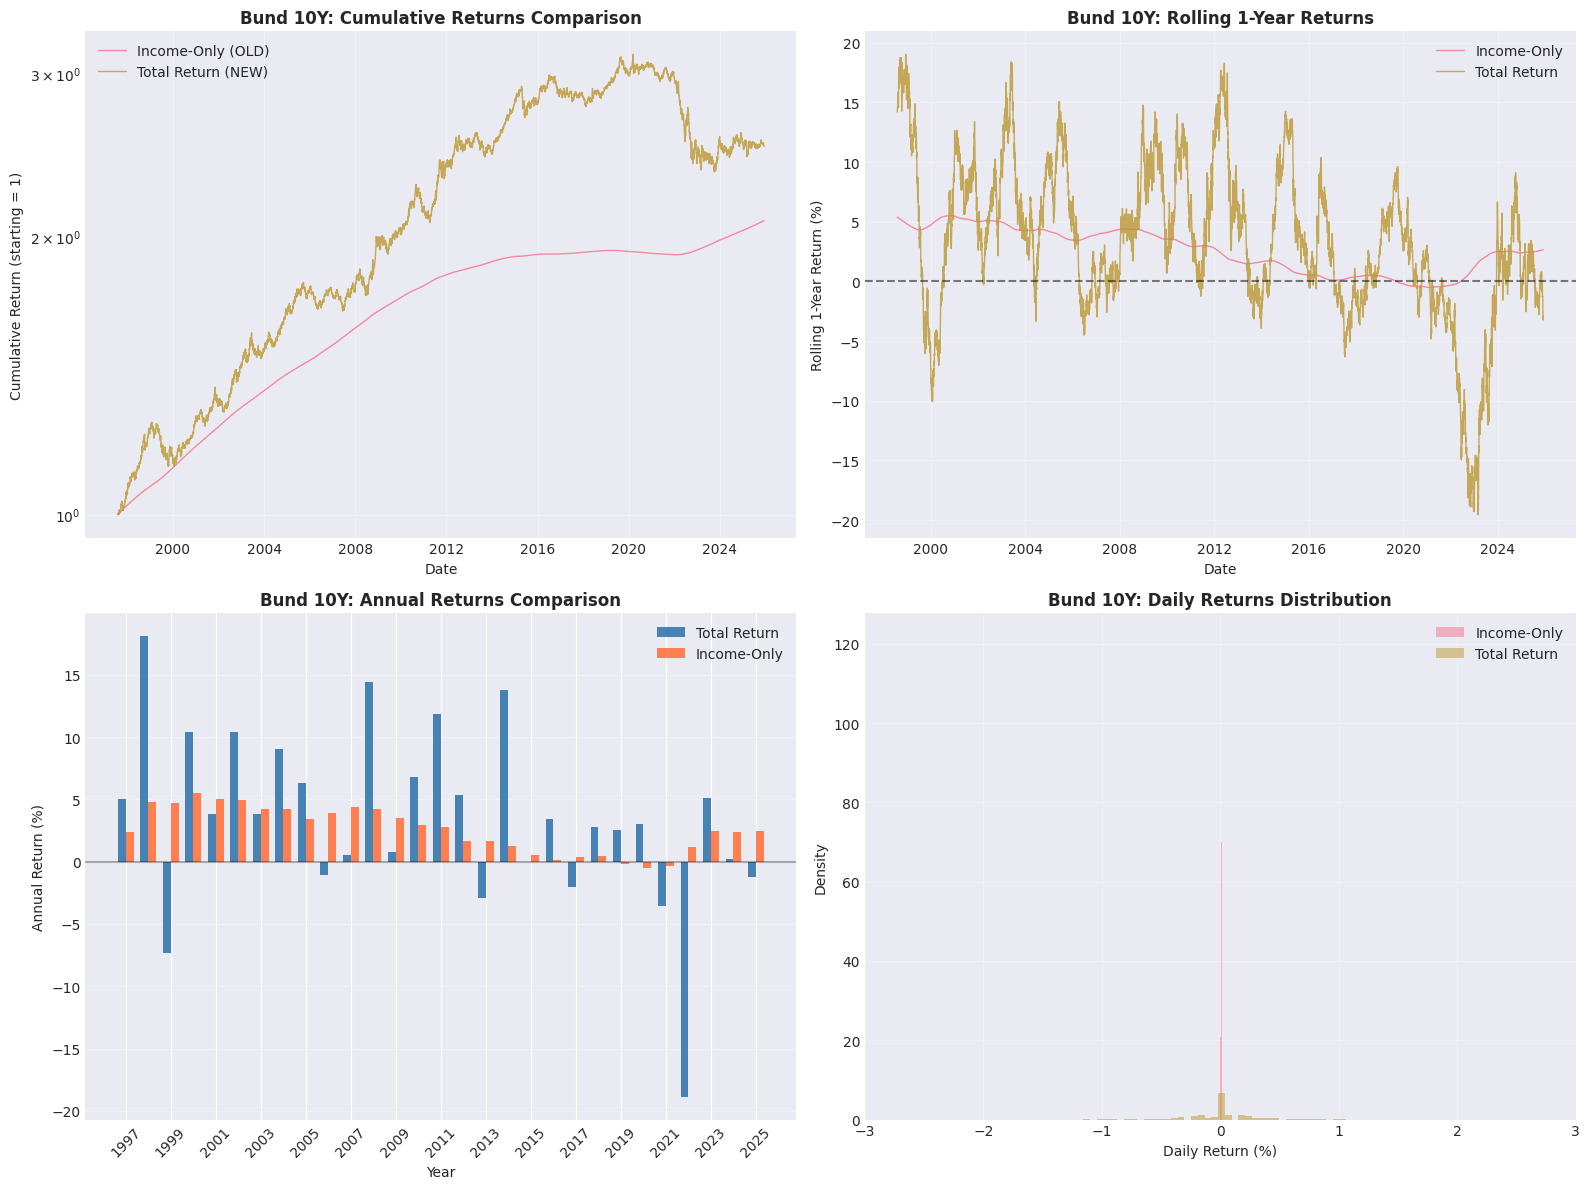


Key Observation: The Total Return method captures the much higher volatility
of bond investments due to duration effects. The Income-Only method severely
underestimates risk and misses capital gains/losses from yield changes.


In [10]:
# ============================================================================
# VISUALIZATION: Cumulative Returns Comparison
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Plot 1: Cumulative returns comparison ---
ax1 = axes[0, 0]

# Calculate cumulative returns (using log returns correctly)
# Note: bund_income_only uses simple returns, bund_total_return uses log returns
cum_income = np.exp(bund_income_only['return'].cumsum())  # income-only still simple, approximate
cum_total = np.exp(bund_total_return['return'].cumsum())   # total return now uses log returns

ax1.plot(bund_income_only['date'], cum_income, label='Income-Only (OLD)', alpha=0.8, linewidth=1)
ax1.plot(bund_total_return['date'], cum_total, label='Total Return (NEW)', alpha=0.8, linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return (starting = 1)')
ax1.set_title('Bund 10Y: Cumulative Returns Comparison', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# --- Plot 2: Rolling 1-year returns comparison ---
ax2 = axes[0, 1]

# Calculate rolling 1-year returns (365 days)
bund_income_only_sorted = bund_income_only.sort_values('date').copy()
bund_total_return_sorted = bund_total_return.sort_values('date').copy()

rolling_income = bund_income_only_sorted['return'].rolling(window=365).apply(
    lambda x: np.exp(x.sum()) - 1
)
rolling_total = bund_total_return_sorted['return'].rolling(window=365).apply(
    lambda x: np.exp(x.sum()) - 1
)

ax2.plot(bund_income_only_sorted['date'], rolling_income * 100, label='Income-Only', alpha=0.8, linewidth=1)
ax2.plot(bund_total_return_sorted['date'], rolling_total * 100, label='Total Return', alpha=0.8, linewidth=1)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Date')
ax2.set_ylabel('Rolling 1-Year Return (%)')
ax2.set_title('Bund 10Y: Rolling 1-Year Returns', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Plot 3: Annual returns bar chart ---
ax3 = axes[1, 0]

years = yearly_comparison['Year'].values
x = np.arange(len(years))
width = 0.35

bars1 = ax3.bar(x - width/2, yearly_comparison['Annual_Return'] * 100, width, 
                label='Total Return', color='steelblue')
bars2 = ax3.bar(x + width/2, yearly_comparison['Annual_Return_Income'] * 100, width, 
                label='Income-Only', color='coral')

ax3.set_xlabel('Year')
ax3.set_ylabel('Annual Return (%)')
ax3.set_title('Bund 10Y: Annual Returns Comparison', fontweight='bold')
ax3.set_xticks(x[::2])  # Show every other year
ax3.set_xticklabels(years[::2], rotation=45)
ax3.legend()
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3, axis='y')

# --- Plot 4: Return distribution comparison ---
ax4 = axes[1, 1]

ax4.hist(bund_income_only['return'] * 100, bins=100, alpha=0.5, label='Income-Only', density=True)
ax4.hist(bund_total_return['return'] * 100, bins=100, alpha=0.5, label='Total Return', density=True)
ax4.set_xlabel('Daily Return (%)')
ax4.set_ylabel('Density')
ax4.set_title('Bund 10Y: Daily Returns Distribution', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-3, 3)

plt.tight_layout()
plt.show()

print("\nKey Observation: The Total Return method captures the much higher volatility")
print("of bond investments due to duration effects. The Income-Only method severely")
print("underestimates risk and misses capital gains/losses from yield changes.")

---

## Equity-Bond Correlation Analysis

### Why Correlation Matters for a Mixed Portfolio

The correlation between equities and bonds is a **critical factor** in determining portfolio risk and the success of a withdrawal strategy. Here's why:

1. **Diversification Benefit**: When equity-bond correlation is **negative**, bonds provide a natural hedge against equity market downturns. During market stress, bonds tend to appreciate (as investors flee to safety and yields fall), partially offsetting equity losses.

2. **Sequence of Returns Risk**: For retirees withdrawing from their portfolio, the **order** of returns matters enormously. A negative equity-bond correlation during crises helps reduce the severity of drawdowns precisely when they are most damaging.

3. **Income-Only vs Total Return**: The income-only method for calculating bond returns **severely underestimates** the true correlation dynamics:
   - It captures only the yield component (which is always positive and relatively stable)
   - It **misses capital gains** when yields fall during crises (flight to quality)
   - It **misses capital losses** when yields rise during inflationary periods
   - Result: Income-only correlation is artificially low and doesn't reflect the true diversification benefit

### What to Expect

The total return method should show:
- **More negative correlation during crises** (2001-2002, 2008, 2020): As investors flee to safe assets, bond prices rise while equities fall
- **More positive correlation during inflationary periods** (2022): Both asset classes suffer when rates rise unexpectedly
- **More variable correlation overall**: The income-only method smooths out the true dynamics

In [11]:
# ============================================================================
# EQUITY-BOND CORRELATION ANALYSIS
# ============================================================================

import warnings

# Define crisis years
CRISIS_YEARS = [2001, 2002, 2008, 2020, 2022]

# --- Prepare data for correlation analysis ---

# Get MSCI Europe returns
msci_returns = assets_returns['MSCI_EUROPE'][['date', 'return']].copy()
msci_returns.columns = ['date', 'msci_return']

# Get Bund returns using both methods
bund_income = calculate_bond_returns_income_only(assets['BUND_10Y'])[['date', 'return']].copy()
bund_income.columns = ['date', 'bund_income_return']

bund_total = calculate_bond_total_returns(assets['BUND_10Y'], duration=8.0)[['date', 'return']].copy()
bund_total.columns = ['date', 'bund_total_return']

# Merge all data on common dates
corr_data = pd.merge(msci_returns, bund_income, on='date', how='inner')
corr_data = pd.merge(corr_data, bund_total, on='date', how='inner')
corr_data = corr_data.sort_values('date').reset_index(drop=True)
corr_data['year'] = pd.to_datetime(corr_data['date']).dt.year

# --- Calculate overall correlations ---
corr_income_overall = corr_data['msci_return'].corr(corr_data['bund_income_return'])
corr_total_overall = corr_data['msci_return'].corr(corr_data['bund_total_return'])

# --- Calculate rolling correlations (365 calendar days = 1 year) ---
ROLLING_WINDOW = 365

# Suppress RuntimeWarnings for correlation calculations (NaN produced when stddev=0)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')
    
    corr_data['rolling_corr_income'] = corr_data['msci_return'].rolling(
        window=ROLLING_WINDOW
    ).corr(corr_data['bund_income_return'])

    corr_data['rolling_corr_total'] = corr_data['msci_return'].rolling(
        window=ROLLING_WINDOW
    ).corr(corr_data['bund_total_return'])

    # --- Calculate correlations by year ---
    yearly_corr = corr_data.groupby('year').apply(
        lambda x: pd.Series({
            'corr_income': x['msci_return'].corr(x['bund_income_return']),
            'corr_total': x['msci_return'].corr(x['bund_total_return']),
            'n_obs': len(x)
        }),
        include_groups=False
    ).reset_index()

# --- Calculate correlations by regime ---
crisis_mask = corr_data['year'].isin(CRISIS_YEARS)
normal_mask = ~crisis_mask

corr_crisis_income = corr_data.loc[crisis_mask, 'msci_return'].corr(
    corr_data.loc[crisis_mask, 'bund_income_return']
)
corr_crisis_total = corr_data.loc[crisis_mask, 'msci_return'].corr(
    corr_data.loc[crisis_mask, 'bund_total_return']
)

corr_normal_income = corr_data.loc[normal_mask, 'msci_return'].corr(
    corr_data.loc[normal_mask, 'bund_income_return']
)
corr_normal_total = corr_data.loc[normal_mask, 'msci_return'].corr(
    corr_data.loc[normal_mask, 'bund_total_return']
)

# --- Print summary table ---
print("=" * 70)
print("EQUITY-BOND CORRELATION ANALYSIS")
print("=" * 70)

print(f"\nPeriod: {corr_data['date'].min().strftime('%Y-%m-%d')} - {corr_data['date'].max().strftime('%Y-%m-%d')}")
print(f"Observations: {len(corr_data):,} days")

print("\n--- Overall Correlation (full period) ---")
print(f"Income-Only Method:  {corr_income_overall:>7.4f}")
print(f"Total Return Method: {corr_total_overall:>7.4f}")
print(f"Difference:          {corr_total_overall - corr_income_overall:>7.4f}")

print("\n--- Correlation by Crisis Year ---")
print(f"{'Year':<8} {'Income-Only':>12} {'Total Return':>13}")
print("-" * 35)
for year in CRISIS_YEARS:
    year_data = yearly_corr[yearly_corr['year'] == year]
    if len(year_data) > 0:
        income_val = year_data['corr_income'].values[0]
        total_val = year_data['corr_total'].values[0]
        print(f"{year:<8} {income_val:>12.4f} {total_val:>13.4f}")
    else:
        print(f"{year:<8} {'N/A':>12} {'N/A':>13}")

print("\n--- Average Correlation by Regime ---")
print(f"{'Regime':<18} {'Income-Only':>12} {'Total Return':>13}")
print("-" * 45)
print(f"{'Crisis years':<18} {corr_crisis_income:>12.4f} {corr_crisis_total:>13.4f}")
print(f"{'Normal years':<18} {corr_normal_income:>12.4f} {corr_normal_total:>13.4f}")

print("\n--- Interpretation ---")
if corr_total_overall < corr_income_overall:
    print(">>> The Total Return method shows MORE NEGATIVE correlation overall.")
    print("    This captures bond price appreciation when equities fall.")
else:
    print(">>> The Income-Only method shows more negative correlation overall.")
    
# Check crisis year behavior
crisis_diff = corr_crisis_total - corr_crisis_income
normal_diff = corr_normal_total - corr_normal_income
if crisis_diff < normal_diff:
    print(">>> The Total Return method better captures the 'flight to quality' effect")
    print("    during crises, when bonds act as a hedge for equities.")

EQUITY-BOND CORRELATION ANALYSIS

Period: 2000-12-30 - 2025-12-03
Observations: 9,105 days

--- Overall Correlation (full period) ---
Income-Only Method:  -0.0142
Total Return Method: -0.2042
Difference:          -0.1901

--- Correlation by Crisis Year ---
Year      Income-Only  Total Return
-----------------------------------
2001          -0.0697       -0.0267
2002           0.0030       -0.4842
2008           0.0147       -0.2851
2020           0.1820       -0.2904
2022           0.0336        0.0964

--- Average Correlation by Regime ---
Regime              Income-Only  Total Return
---------------------------------------------
Crisis years            -0.0217       -0.1980
Normal years             0.0032       -0.2133

--- Interpretation ---
>>> The Total Return method shows MORE NEGATIVE correlation overall.
    This captures bond price appreciation when equities fall.


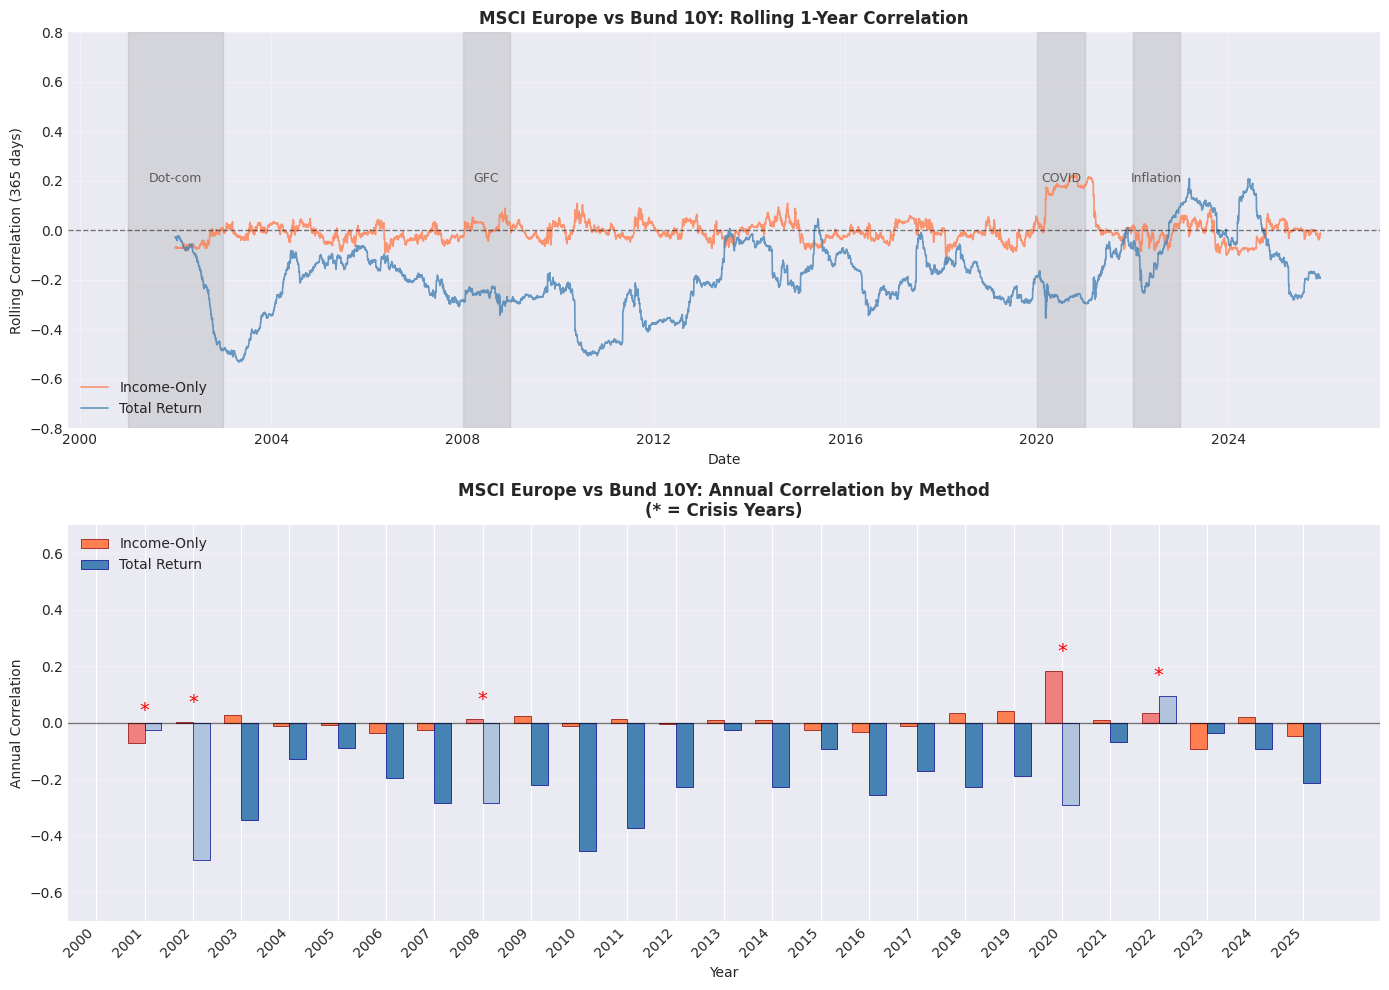


Key Observations:
--------------------------------------------------
Most negative correlation (Total Return): 2002 (-0.4842)
Most positive correlation (Total Return): 2022 (0.0964)

Average correlation difference in crisis years: -0.2307
(Negative = Total Return shows more negative correlation during crises)


In [12]:
# ============================================================================
# VISUALIZATION: Equity-Bond Correlation
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# --- Subplot 1: Rolling Correlation (365 days) ---
ax1 = axes[0]

# Plot rolling correlations
ax1.plot(corr_data['date'], corr_data['rolling_corr_income'], 
         label='Income-Only', alpha=0.8, linewidth=1.2, color='coral')
ax1.plot(corr_data['date'], corr_data['rolling_corr_total'], 
         label='Total Return', alpha=0.8, linewidth=1.2, color='steelblue')

# Add zero line
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Highlight crisis years with vertical bands
crisis_periods = [
    ('2001-01-01', '2002-12-31', 'Dot-com'),
    ('2008-01-01', '2008-12-31', 'GFC'),
    ('2020-01-01', '2020-12-31', 'COVID'),
    ('2022-01-01', '2022-12-31', 'Inflation')
]

for start, end, label in crisis_periods:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    if start_date >= corr_data['date'].min() and end_date <= corr_data['date'].max():
        ax1.axvspan(start_date, end_date, alpha=0.2, color='gray')
        # Add label at top of band
        mid_date = start_date + (end_date - start_date) / 2
        ax1.text(mid_date, ax1.get_ylim()[1] * 0.9 if ax1.get_ylim()[1] > 0 else 0.7, 
                 label, ha='center', va='top', fontsize=9, alpha=0.7)

ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Correlation (365 days)')
ax1.set_title('MSCI Europe vs Bund 10Y: Rolling 1-Year Correlation', fontweight='bold')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.8, 0.8)

# --- Subplot 2: Bar Chart by Year ---
ax2 = axes[1]

# Prepare data for bar chart
years = yearly_corr['year'].values
x = np.arange(len(years))
width = 0.35

# Color bars differently for crisis years
colors_income = ['lightcoral' if y in CRISIS_YEARS else 'coral' for y in years]
colors_total = ['lightsteelblue' if y in CRISIS_YEARS else 'steelblue' for y in years]

bars1 = ax2.bar(x - width/2, yearly_corr['corr_income'], width, 
                label='Income-Only', color=colors_income, edgecolor='darkred', linewidth=0.5)
bars2 = ax2.bar(x + width/2, yearly_corr['corr_total'], width, 
                label='Total Return', color=colors_total, edgecolor='darkblue', linewidth=0.5)

# Add zero line
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Mark crisis years
for i, year in enumerate(years):
    if year in CRISIS_YEARS:
        ax2.annotate('*', xy=(i, max(yearly_corr.loc[yearly_corr['year'] == year, 'corr_income'].values[0],
                                      yearly_corr.loc[yearly_corr['year'] == year, 'corr_total'].values[0]) + 0.05),
                    ha='center', fontsize=14, color='red')

ax2.set_xlabel('Year')
ax2.set_ylabel('Annual Correlation')
ax2.set_title('MSCI Europe vs Bund 10Y: Annual Correlation by Method\n(* = Crisis Years)', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(years, rotation=45, ha='right')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(-0.7, 0.7)

plt.tight_layout()
plt.show()

# Print additional insights
print("\nKey Observations:")
print("-" * 50)

# Find year with most negative correlation
most_negative_year = yearly_corr.loc[yearly_corr['corr_total'].idxmin()]
print(f"Most negative correlation (Total Return): {most_negative_year['year']:.0f} ({most_negative_year['corr_total']:.4f})")

# Find year with most positive correlation
most_positive_year = yearly_corr.loc[yearly_corr['corr_total'].idxmax()]
print(f"Most positive correlation (Total Return): {most_positive_year['year']:.0f} ({most_positive_year['corr_total']:.4f})")

# Calculate average absolute difference between methods during crises
crisis_years_data = yearly_corr[yearly_corr['year'].isin(CRISIS_YEARS)]
avg_diff_crisis = (crisis_years_data['corr_total'] - crisis_years_data['corr_income']).mean()
print(f"\nAverage correlation difference in crisis years: {avg_diff_crisis:+.4f}")
print("(Negative = Total Return shows more negative correlation during crises)")

---

## 5. Portfolio Configuration

### Portfolio Allocation
- **90% MSCI Europe (Net Total Return)**: European equity exposure across developed markets, dividends reinvested net of withholding taxes
- **10% Bund 10Y**: German government bonds (safe haven asset)

### Simulation Parameters
- **Initial portfolio**: €1,000,000
- **Withdrawal rate**: 4% annually (inflation-adjusted)
- **Retirement horizon**: 30 years
- **Block size**: 6 months (~180 calendar days)
- **Simulations**: 100,000 runs
- **Inflation**: Euro area HICP

### Tax Assumptions
- **No capital gains tax**: Withdrawals are assumed to be tax-free
- This simplification is appropriate for:
  - Tax-advantaged retirement accounts
  - Jurisdictions without capital gains tax
  - Long-term holdings exempt from taxation
  - Theoretical baseline analysis

### Customization
All parameters can be easily modified in this cell to test different scenarios.


In [13]:
# Portfolio allocation (must sum to 1.0)
PORTFOLIO_WEIGHTS = {
    'MSCI_EUROPE': 0.90,  # 90% European stocks (Net Total Return)
    'BUND_10Y': 0.10,     # 10% German bonds
}

# Inflation to use
INFLATION_SERIES = 'HICP_EU'  # EU harmonized inflation

# Block bootstrap parameters
BLOCK_SIZE_MONTHS = 6  # Size of blocks in months (can be adjusted)

# Portfolio parameters
INITIAL_PORTFOLIO = 1000000  # Initial portfolio in EUR
ANNUAL_WITHDRAWAL_RATE = 0.04  # 4% initial SWR
RETIREMENT_YEARS = 30  # Retirement duration in years

# Tax assumption: NO capital gains tax applied on withdrawals
# This is an idealized scenario - in reality, withdrawals may be subject to taxation
# depending on the jurisdiction and account type (taxable vs tax-advantaged)
TAX_ON_WITHDRAWALS = False  # No tax applied

# Monte Carlo parameters
# With parallel processing via joblib, 100k simulations run much faster
# Recommended: 100000 for production (reduce for quick testing)
N_SIMULATIONS = 100000  # Number of simulations
SEED = 42  # For reproducibility

np.random.seed(SEED)

# Validate weights
total_weight = sum(PORTFOLIO_WEIGHTS.values())
assert abs(total_weight - 1.0) < 0.001, f"Portfolio weights must sum to 1.0, got {total_weight}"

print(f"Portfolio allocation:")
for asset, weight in PORTFOLIO_WEIGHTS.items():
    print(f"  {asset}: {weight:.1%}")
print(f"\nInflation series: {INFLATION_SERIES}")
print(f"Block size: {BLOCK_SIZE_MONTHS} months")
print(f"Number of simulations: {N_SIMULATIONS:,}")
print(f"Random seed: {SEED}")
print(f"\nTax on withdrawals: {'Yes' if TAX_ON_WITHDRAWALS else 'No (tax-free withdrawals)'}")

Portfolio allocation:
  MSCI_EUROPE: 90.0%
  BUND_10Y: 10.0%

Inflation series: HICP_EU
Block size: 6 months
Number of simulations: 100,000
Random seed: 42

Tax on withdrawals: No (tax-free withdrawals)


---

## 6. Prepare Combined Dataset

### Data Merging Process
1. Find common time window across all assets (latest start date to earliest end date)
2. Filter each asset to the common time window
3. Merge asset returns on common dates (outer join)
4. Calculate weighted portfolio return: 0.9×MSCI_EUROPE + 0.1×Bund_10Y
5. Upsample monthly inflation to daily frequency
6. Backward-fill missing values (using future known values)
7. Drop any remaining NaN values at the beginning

### Why Backward-Fill?
Using backward-fill (bfill) instead of forward-fill ensures that:
- Missing values are filled with the next available known value
- This avoids look-ahead bias in the opposite direction
- More conservative approach for missing data imputation

### Output
- Combined dataset with daily portfolio returns and inflation
- Summary statistics (annualized using 365 days/year)

In [14]:
# Merge selected assets
selected_assets = {name: assets_returns[name] for name in PORTFOLIO_WEIGHTS.keys()}

# Find common time window across all assets
# Start date: maximum of all minimum dates (latest start)
# End date: minimum of all maximum dates (earliest end)
common_start = max(df['date'].min() for df in selected_assets.values())
common_end = min(df['date'].max() for df in selected_assets.values())

print(f"Finding common time window:")
for name, df in selected_assets.items():
    print(f"  {name}: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"\nCommon time window: {common_start.strftime('%Y-%m-%d')} to {common_end.strftime('%Y-%m-%d')}")

# Filter each asset to common time window before merging
selected_assets_filtered = {}
for name, df in selected_assets.items():
    df_filtered = df[(df['date'] >= common_start) & (df['date'] <= common_end)].copy()
    selected_assets_filtered[name] = df_filtered
    print(f"  {name} filtered: {len(df_filtered)} observations")

returns_df = merge_to_common_dates(selected_assets_filtered)

# Calculate portfolio daily return
# Note: Log returns are NOT cross-sectionally additive, so we must convert
# to growth factors, aggregate, then convert back to log return
returns_df['portfolio_return'] = calculate_portfolio_log_return(
    returns_df, PORTFOLIO_WEIGHTS
)

# Add inflation
inflation_df = inflation_returns[INFLATION_SERIES]
inflation_daily = upsample_inflation_to_daily(
    inflation_df,
    returns_df['date'].min(),
    returns_df['date'].max()
)

# Merge inflation
returns_df = pd.merge(returns_df, inflation_daily, on='date', how='left')

# Backward fill missing values (bfill) then drop any remaining NaN at the start
returns_df = returns_df.bfill().dropna()

print(f"\nCombined dataset:")
print(f"  Date range: {returns_df['date'].min()} to {returns_df['date'].max()}")
print(f"  Total days: {len(returns_df):,}")
print(f"\nFirst few rows:")
print(returns_df.head())

print(f"\nSummary statistics (annualized):")
print(f"  Portfolio return: {returns_df['portfolio_return'].mean() * 365:.2%} ± {returns_df['portfolio_return'].std() * np.sqrt(365):.2%}")
print(f"  Inflation: {returns_df['inflation'].mean() * 365:.2%}")

Finding common time window:
  MSCI_EUROPE: 2000-12-30 to 2025-12-03
  BUND_10Y: 1997-08-02 to 2025-12-05

Common time window: 2000-12-30 to 2025-12-03
  MSCI_EUROPE filtered: 9105 observations
  BUND_10Y filtered: 9105 observations

Combined dataset:
  Date range: 2000-12-30 00:00:00 to 2025-10-31 00:00:00
  Total days: 9,072

First few rows:
        date  MSCI_EUROPE  BUND_10Y  portfolio_return  inflation
0 2000-12-30     0.000000  0.007305          0.000733   0.000120
1 2000-12-31     0.000000  0.000132          0.000013   0.000120
2 2001-01-01     0.000000  0.000132          0.000013  -0.000151
3 2001-01-02    -0.013588  0.000132         -0.012207  -0.000151
4 2001-01-03    -0.011406  0.004122         -0.009842  -0.000151

Summary statistics (annualized):
  Portfolio return: 4.35% ± 16.69%
  Inflation: 2.10%


---

## 7. Monte Carlo Simulation Functions

### Single Portfolio Simulation
`simulate_portfolio_bootstrap()` simulates one retirement scenario:
1. **Bootstrap sample**: Generate 30 years of returns using block bootstrap
2. **Annual loop**: For each year:
   - Compound daily returns to get annual return
   - Compound daily inflation to get annual inflation
   - Adjust withdrawal for inflation (after year 1)
   - Withdraw at beginning of year
   - Apply investment returns
3. **Portfolio tracking**: Record value each year

### Monte Carlo Runner
`run_monte_carlo_bootstrap()` runs 100,000 independent simulations:
- Each simulation uses different random block samples
- Tracks all portfolio paths
- Calculates success rate (portfolio > 0 after 30 years)

In [15]:
def simulate_portfolio_bootstrap(
    initial_portfolio: float,
    withdrawal_rate: float,
    years: int,
    returns_data: pd.DataFrame,
    block_size_months: int = 6,
    adjust_for_inflation: bool = True,
    rng: np.random.Generator = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate portfolio evolution using block bootstrap.
    
    Note: This simulation assumes NO capital gains tax on withdrawals.
    The full withdrawal amount is taken from the portfolio without any
    tax deduction. For taxed scenarios, the withdrawal amount should be
    grossed up to account for the applicable tax rate.
    
    Args:
        initial_portfolio: Initial portfolio value
        withdrawal_rate: Annual withdrawal rate
        years: Number of years to simulate
        returns_data: Historical returns data
        block_size_months: Block size for bootstrap
        adjust_for_inflation: Whether to adjust withdrawals for inflation
        rng: numpy random Generator for reproducibility (optional)
    
    Returns:
        Tuple of (portfolio_values, withdrawal_amounts)
    """
    # Generate bootstrap sample
    bootstrap_data = block_bootstrap_sample(
        returns_data[['portfolio_return', 'inflation']],
        block_size_months=block_size_months,
        n_years=years,
        rng=rng
    )
    
    # Convert daily returns to yearly
    days_per_year = len(bootstrap_data) // years
    
    portfolio = np.zeros(years + 1)
    portfolio[0] = initial_portfolio
    
    withdrawals = np.zeros(years)
    annual_withdrawal = initial_portfolio * withdrawal_rate
    
    for year in range(years):
        # Get this year's daily returns
        start_idx = year * days_per_year
        end_idx = (year + 1) * days_per_year
        
        year_data = bootstrap_data.iloc[start_idx:end_idx]
        
        # Annual return (compound daily returns)
        annual_return = np.exp(year_data['portfolio_return'].sum()) - 1
        
        # Annual inflation (compound daily inflation)
        annual_inflation = np.exp(year_data['inflation'].sum()) - 1
        
        # Adjust withdrawal for inflation if requested
        if adjust_for_inflation and year > 0:
            annual_withdrawal *= (1 + annual_inflation)
        
        withdrawals[year] = annual_withdrawal
        
        # Withdrawal at the beginning of the year
        # NOTE: No capital gains tax is applied - the full withdrawal amount
        # is taken from the portfolio. In a taxed scenario, to receive the same
        # net amount, a higher gross withdrawal would be needed.
        portfolio[year + 1] = portfolio[year] - annual_withdrawal
        
        # Apply returns
        if portfolio[year + 1] > 0:
            portfolio[year + 1] *= (1 + annual_return)
        else:
            portfolio[year + 1] = 0  # Portfolio depleted
    
    return portfolio, withdrawals


def _run_single_simulation(
    sim_id: int,
    seed: int,
    initial_portfolio: float,
    withdrawal_rate: float,
    years: int,
    returns_data: pd.DataFrame,
    block_size_months: int,
    adjust_for_inflation: bool
) -> Tuple[int, np.ndarray, bool]:
    """
    Wrapper function to run a single simulation with deterministic seed.
    
    Args:
        sim_id: Simulation identifier
        seed: Deterministic seed for this simulation's RNG
        initial_portfolio: Initial portfolio value
        withdrawal_rate: Annual withdrawal rate
        years: Number of years to simulate
        returns_data: Historical returns data
        block_size_months: Block size for bootstrap
        adjust_for_inflation: Whether to adjust withdrawals for inflation
    
    Returns:
        Tuple of (simulation_id, portfolio_values, success)
    """
    # Create deterministic generator for this simulation
    rng = np.random.default_rng(seed)
    
    portfolio, _ = simulate_portfolio_bootstrap(
        initial_portfolio,
        withdrawal_rate,
        years,
        returns_data,
        block_size_months,
        adjust_for_inflation,
        rng=rng
    )
    success = portfolio[-1] > 0
    return sim_id, portfolio, success


def run_monte_carlo_bootstrap(
    n_simulations: int,
    initial_portfolio: float,
    withdrawal_rate: float,
    years: int,
    returns_data: pd.DataFrame,
    block_size_months: int = 6,
    adjust_for_inflation: bool = True,
    n_jobs: int = -1,
    base_seed: int = 42
) -> Tuple[np.ndarray, float]:
    """
    Run Monte Carlo simulations using block bootstrap with parallel processing.
    
    Note: All simulations assume NO capital gains tax on withdrawals.
    
    REPRODUCIBILITY: Each simulation receives a deterministic seed = base_seed + sim_id
    
    Args:
        n_simulations: Number of simulations to run
        initial_portfolio: Initial portfolio value
        withdrawal_rate: Annual withdrawal rate
        years: Number of years to simulate
        returns_data: Historical returns data
        block_size_months: Block size for bootstrap
        adjust_for_inflation: Whether to adjust withdrawals for inflation
        n_jobs: Number of parallel jobs (-1 uses all available CPUs)
        base_seed: Base seed for reproducibility (each simulation uses base_seed + sim_id)
    
    Returns:
        Tuple of (all_portfolios, success_rate)
    """
    print(f"  Running {n_simulations:,} simulations using {n_jobs if n_jobs > 0 else 'all available'} CPU(s)...")
    print(f"  Base seed: {base_seed} (reproducible)")
    
    # Run simulations in parallel with deterministic seeds
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(_run_single_simulation)(
            i,
            base_seed + i,  # Deterministic seed for each simulation
            initial_portfolio,
            withdrawal_rate,
            years,
            returns_data,
            block_size_months,
            adjust_for_inflation
        )
        for i in range(n_simulations)
    )
    
    # Collect results
    all_portfolios = np.zeros((n_simulations, years + 1))
    successes = 0
    
    for sim_id, portfolio, success in results:
        all_portfolios[sim_id] = portfolio
        if success:
            successes += 1
    
    success_rate = successes / n_simulations
    return all_portfolios, success_rate

---

## 8. Run Base Simulation

Executing 100,000 Monte Carlo simulations with 4% withdrawal rate.

**Expected runtime**: 2-5 minutes depending on system

In [16]:
print(f"Running {N_SIMULATIONS:,} Monte Carlo simulations...")
portfolios, success_rate = run_monte_carlo_bootstrap(
    N_SIMULATIONS,
    INITIAL_PORTFOLIO,
    ANNUAL_WITHDRAWAL_RATE,
    RETIREMENT_YEARS,
    returns_df,
    BLOCK_SIZE_MONTHS,
    base_seed=SEED
)

print(f"\nResults:")
print(f"  Success rate: {success_rate:.2%}")
print(f"  Median final value: €{np.median(portfolios[:, -1]):,.0f}")
print(f"  Mean final value: €{np.mean(portfolios[:, -1]):,.0f}")

Running 100,000 Monte Carlo simulations...
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19570524466387512s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.052663564682006836s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06792616844177246s.) Setting batch_size=8.
[Parallel(n_jo


Results:
  Success rate: 60.85%
  Median final value: €434,461
  Mean final value: €1,678,483


[Parallel(n_jobs=-1)]: Done 99753 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 100000 out of 100000 | elapsed:   24.0s finished


In [17]:
# === TEST REPRODUCIBILITY ===
# Run this cell to verify that simulations are deterministic

def test_reproducibility(n_test=1000):
    """Verify that simulations are reproducible."""
    print("Testing reproducibility...")
    
    p1, sr1 = run_monte_carlo_bootstrap(
        n_test, INITIAL_PORTFOLIO, ANNUAL_WITHDRAWAL_RATE,
        RETIREMENT_YEARS, returns_df, BLOCK_SIZE_MONTHS,
        n_jobs=-1, base_seed=42
    )
    
    p2, sr2 = run_monte_carlo_bootstrap(
        n_test, INITIAL_PORTFOLIO, ANNUAL_WITHDRAWAL_RATE,
        RETIREMENT_YEARS, returns_df, BLOCK_SIZE_MONTHS,
        n_jobs=-1, base_seed=42
    )
    
    assert sr1 == sr2, f"Success rates differ: {sr1} vs {sr2}"
    assert np.allclose(p1, p2), "Portfolio paths differ!"
    print("✓ Reproducibility verified!")

# Uncomment to run the test:
# test_reproducibility()

---

## 9. Results Visualization

### Portfolio Evolution Chart
Shows percentile bands across 30-year horizon:
- **5th percentile**: Lower bound scenarios
- **25th percentile**: Below-average outcomes
- **50th percentile** (median): Central tendency
- **75th percentile**: Above-average outcomes
- **95th percentile**: Upper bound scenarios

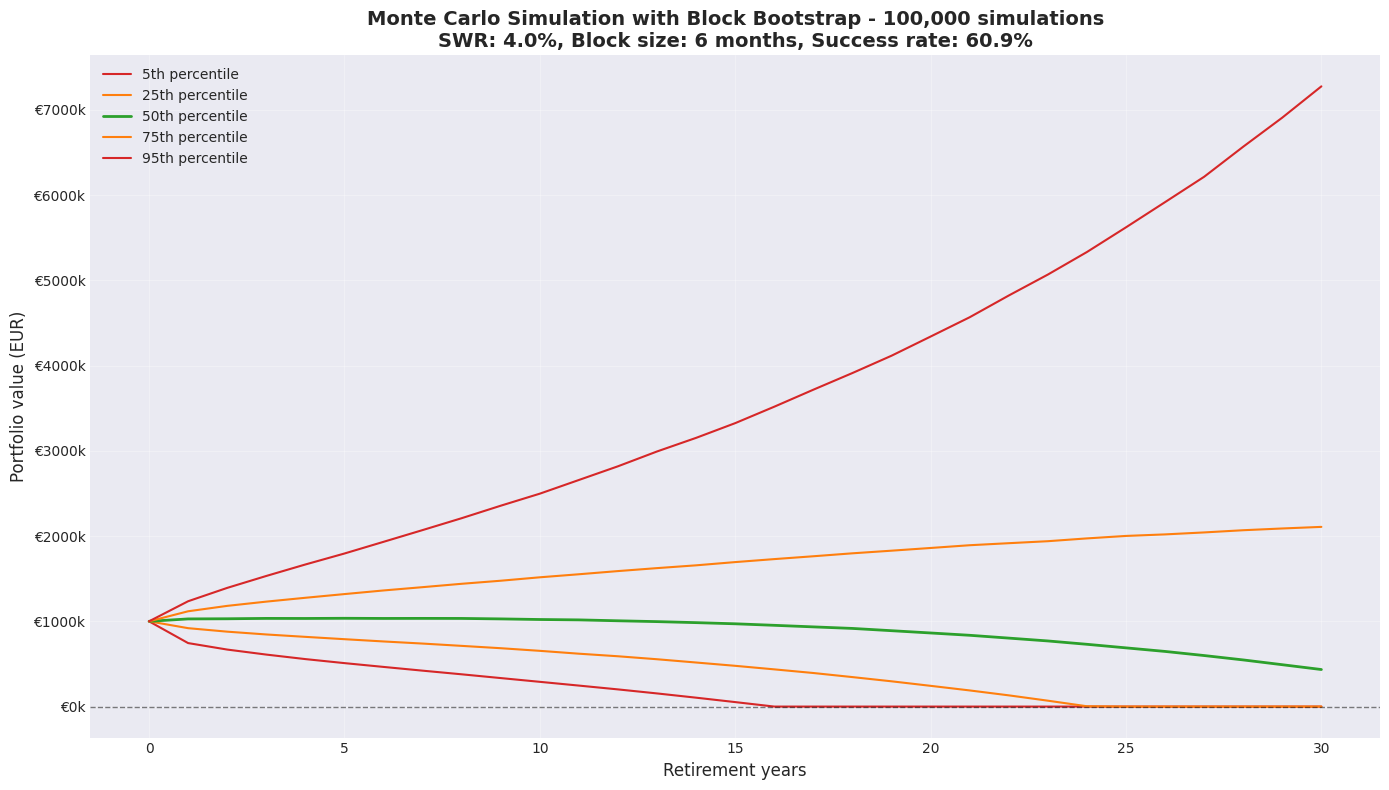

In [18]:
# Portfolio evolution plot
fig, ax = plt.subplots(figsize=(14, 8))

years = np.arange(0, RETIREMENT_YEARS + 1)

# Percentiles
percentiles = [5, 25, 50, 75, 95]
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#ff7f0e', '#d62728']

for i, p in enumerate(percentiles):
    values = np.percentile(portfolios, p, axis=0)
    ax.plot(years, values, label=f'{p}th percentile', 
            color=colors[i], linewidth=2 if p == 50 else 1.5)

# Zero line
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Retirement years', fontsize=12)
ax.set_ylabel('Portfolio value (EUR)', fontsize=12)
ax.set_title(
    f'Monte Carlo Simulation with Block Bootstrap - {N_SIMULATIONS:,} simulations\n'
    f'SWR: {ANNUAL_WITHDRAWAL_RATE:.1%}, Block size: {BLOCK_SIZE_MONTHS} months, Success rate: {success_rate:.1%}',
    fontsize=14, fontweight='bold'
)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

### Final Portfolio Values Distribution

Histogram showing distribution of portfolio values after 30 years:
- Values **below zero** (left of red line): Failed scenarios
- Values **above zero**: Successful scenarios
- **Green line**: Median final value

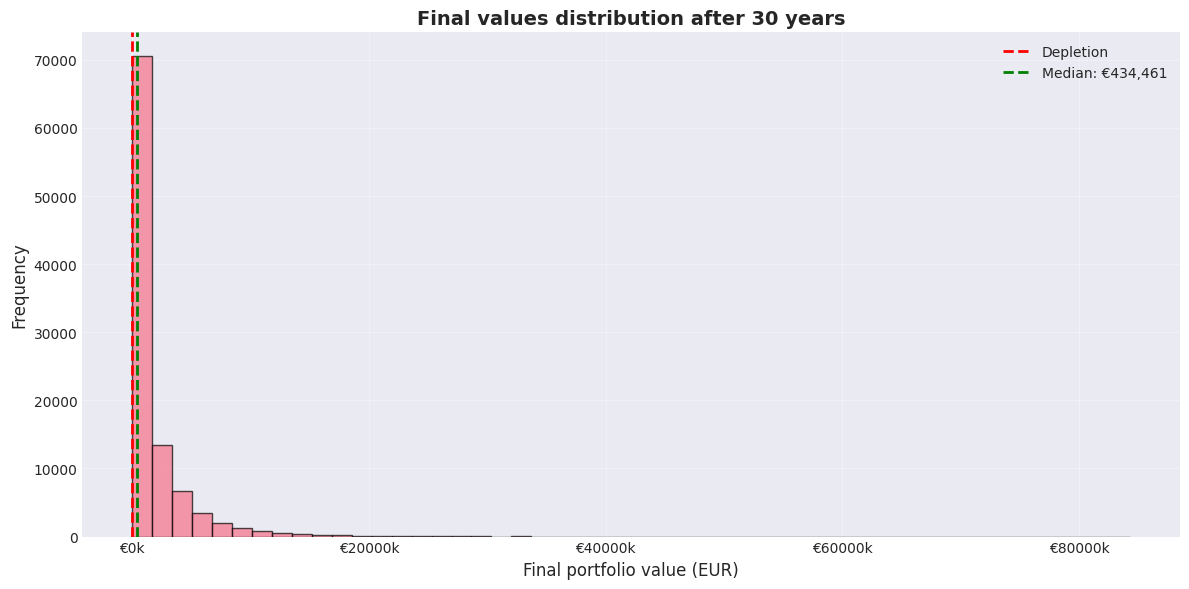

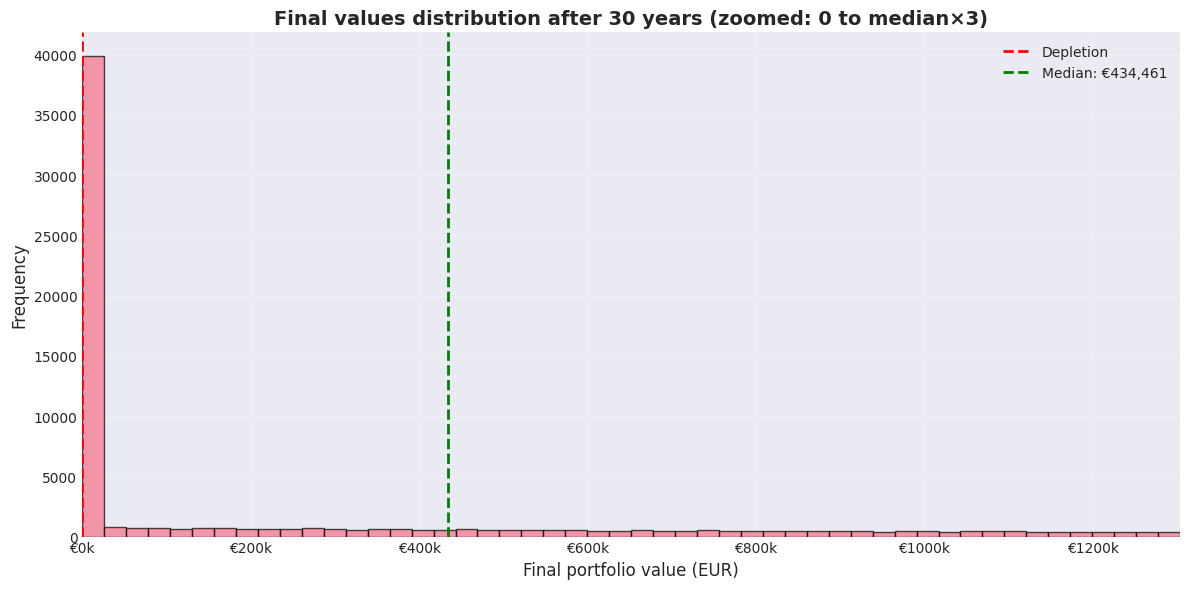

In [19]:
# Final values distribution
fig, ax = plt.subplots(figsize=(12, 6))

final_values = portfolios[:, -1]
ax.hist(final_values, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Depletion')
ax.axvline(x=np.median(final_values), color='green', linestyle='--',
           linewidth=2, label=f'Median: €{np.median(final_values):,.0f}')

ax.set_xlabel('Final portfolio value (EUR)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(
    f'Final values distribution after {RETIREMENT_YEARS} years',
    fontsize=14, fontweight='bold'
)
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

# Final values distribution - ZOOMED (0 to median * 3)
fig, ax = plt.subplots(figsize=(12, 6))

median_value = np.median(final_values)
max_x = median_value * 3

# Filter values for the zoomed view (only for counting, we still plot all data)
ax.hist(final_values, bins=50, edgecolor='black', alpha=0.7, range=(final_values.min(), max_x))
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Depletion')
ax.axvline(x=median_value, color='green', linestyle='--',
           linewidth=2, label=f'Median: €{median_value:,.0f}')

ax.set_xlabel('Final portfolio value (EUR)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(
    f'Final values distribution after {RETIREMENT_YEARS} years (zoomed: 0 to median×3)',
    fontsize=14, fontweight='bold'
)
ax.set_xlim(0, max_x)
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

---

## 10. Sensitivity Analysis

### Withdrawal Rate Impact
Testing withdrawal rates from 2% to 5% (in 0.1% increments) to understand:
- How success rate changes with withdrawal rate
- What is the maximum sustainable withdrawal rate?
- Trade-off between spending and portfolio longevity

**Expected runtime**: 15-30 minutes (10 different rates × 100,000 simulations each)

In [20]:
# Test different withdrawal rates
withdrawal_rates = np.arange(0.02, 0.051, 0.001)
success_rates = []

print("Testing different withdrawal rates...")
for wr in withdrawal_rates:
    print(f"\nWithdrawal rate: {wr:.1%}")
    _, sr = run_monte_carlo_bootstrap(
        N_SIMULATIONS,
        INITIAL_PORTFOLIO,
        wr,
        RETIREMENT_YEARS,
        returns_df,
        BLOCK_SIZE_MONTHS
    )
    success_rates.append(sr)
    print(f"  Success rate: {sr:.2%}")

# Create results DataFrame
df_wr = pd.DataFrame({
    'Withdrawal_Rate': withdrawal_rates,
    'Success_Rate': success_rates
})

print("\nSummary:")
print(df_wr)

Testing different withdrawal rates...

Withdrawal rate: 2.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007729053497314453s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06139540672302246s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06365418434143066s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jo

  Success rate: 94.58%

Withdrawal rate: 2.1%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0822591781616211s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1169443130493164s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:  

  Success rate: 93.57%

Withdrawal rate: 2.2%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07836389541625977s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12912392616271973s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 92.46%

Withdrawal rate: 2.3%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08429694175720215s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11369657516479492s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 91.28%

Withdrawal rate: 2.4%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0821232795715332s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1368086338043213s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:   

  Success rate: 90.05%

Withdrawal rate: 2.5%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07688498497009277s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12067842483520508s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 88.67%

Withdrawal rate: 2.6%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0801534652709961s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12131214141845703s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:  

  Success rate: 87.16%

Withdrawal rate: 2.7%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08344340324401855s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1293182373046875s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed: 

  Success rate: 85.55%

Withdrawal rate: 2.8%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08728170394897461s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10140609741210938s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:

  Success rate: 83.97%

Withdrawal rate: 2.9%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07791018486022949s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13395142555236816s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:

  Success rate: 82.23%

Withdrawal rate: 3.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07949209213256836s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1286475658416748s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:  

  Success rate: 80.43%

Withdrawal rate: 3.1%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0798795223236084s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1371598243713379s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:  

  Success rate: 78.64%

Withdrawal rate: 3.2%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07972502708435059s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.135206937789917s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:   

  Success rate: 76.79%

Withdrawal rate: 3.3%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0803840160369873s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12755751609802246s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:  

  Success rate: 74.83%

Withdrawal rate: 3.4%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07797718048095703s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13800930976867676s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 72.91%

Withdrawal rate: 3.5%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07736635208129883s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13250732421875s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    

  Success rate: 70.95%

Withdrawal rate: 3.6%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08218073844909668s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1163625717163086s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:  

  Success rate: 68.94%

Withdrawal rate: 3.7%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07709956169128418s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12678003311157227s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 66.95%

Withdrawal rate: 3.8%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07799911499023438s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14720416069030762s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 64.92%

Withdrawal rate: 3.9%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07932496070861816s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12334227561950684s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:

  Success rate: 62.92%

Withdrawal rate: 4.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07762479782104492s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12502169609069824s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:

  Success rate: 60.85%

Withdrawal rate: 4.1%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0800631046295166s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12599539756774902s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed: 

  Success rate: 58.80%

Withdrawal rate: 4.2%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0748753547668457s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14594101905822754s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:  

  Success rate: 56.76%

Withdrawal rate: 4.3%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08483719825744629s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1400003433227539s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1987466812133789s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]:

  Success rate: 54.75%

Withdrawal rate: 4.4%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08095479011535645s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13134002685546875s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:

  Success rate: 52.75%

Withdrawal rate: 4.5%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08122682571411133s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13288283348083496s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 50.76%

Withdrawal rate: 4.6%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07947182655334473s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12671375274658203s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 48.80%

Withdrawal rate: 4.7%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07910704612731934s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1341111660003662s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:  

  Success rate: 46.83%

Withdrawal rate: 4.8%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07767343521118164s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12981247901916504s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:

  Success rate: 44.89%

Withdrawal rate: 4.9%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.079071044921875s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13547110557556152s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:   

  Success rate: 43.03%

Withdrawal rate: 5.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07489466667175293s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12946867942810059s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed: 

  Success rate: 41.15%

Summary:
    Withdrawal_Rate  Success_Rate
0             0.020       0.94582
1             0.021       0.93569
2             0.022       0.92462
3             0.023       0.91279
4             0.024       0.90055
5             0.025       0.88670
6             0.026       0.87158
7             0.027       0.85548
8             0.028       0.83973
9             0.029       0.82226
10            0.030       0.80433
11            0.031       0.78636
12            0.032       0.76794
13            0.033       0.74834
14            0.034       0.72906
15            0.035       0.70953
16            0.036       0.68938
17            0.037       0.66955
18            0.038       0.64924
19            0.039       0.62921
20            0.040       0.60854
21            0.041       0.58796
22            0.042       0.56760
23            0.043       0.54750
24            0.044       0.52750
25            0.045       0.50762
26            0.046       0.48805
27            0

[Parallel(n_jobs=-1)]: Done 100000 out of 100000 | elapsed:   23.6s finished


### Sensitivity Curve

This chart shows the relationship between withdrawal rate and success probability:
- **99% threshold** (green): Conservative safety level
- **95% threshold** (orange): Moderate safety level
- **90% threshold** (red): Acceptable risk level
- Find the withdrawal rate that meets your risk tolerance

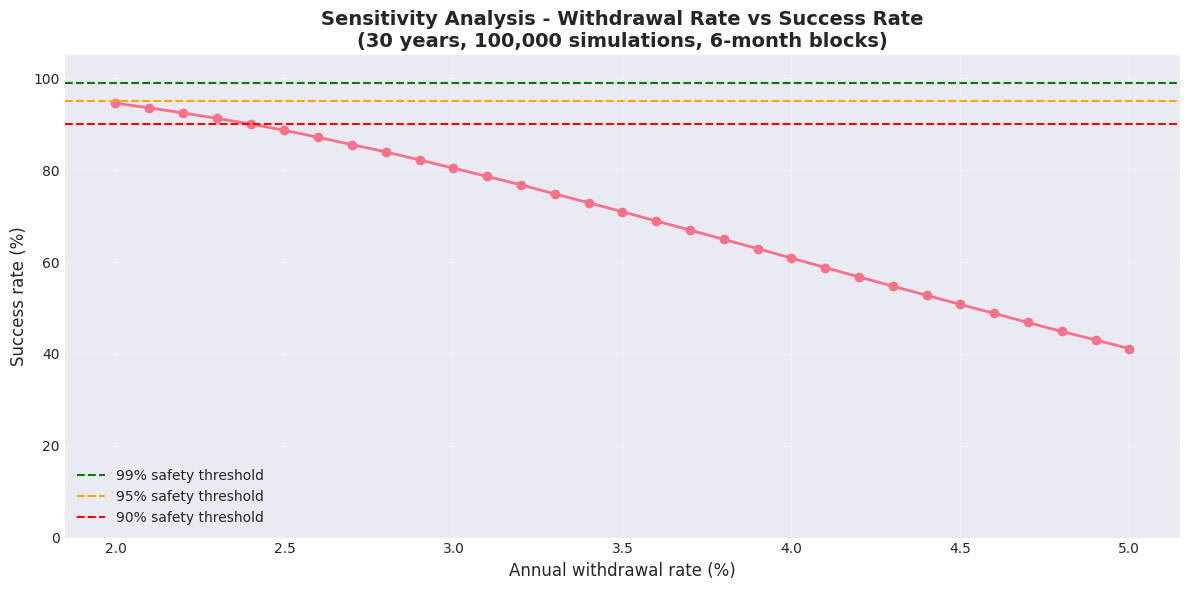

In [21]:
# Withdrawal rate sensitivity plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(withdrawal_rates * 100, np.array(success_rates) * 100, 
        marker='o', linewidth=2, markersize=6)
ax.axhline(y=99, color='green', linestyle='--', label='99% safety threshold')
ax.axhline(y=95, color='orange', linestyle='--', label='95% safety threshold')
ax.axhline(y=90, color='red', linestyle='--', label='90% safety threshold')

ax.set_xlabel('Annual withdrawal rate (%)', fontsize=12)
ax.set_ylabel('Success rate (%)', fontsize=12)
ax.set_title(
    f'Sensitivity Analysis - Withdrawal Rate vs Success Rate\n'
    f'({RETIREMENT_YEARS} years, {N_SIMULATIONS:,} simulations, {BLOCK_SIZE_MONTHS}-month blocks)',
    fontsize=14, fontweight='bold'
)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

---

## 11. Detailed Statistical Analysis

### Year-by-Year Statistics
For each year of retirement, showing:
- **Median/Mean**: Central tendency
- **P5/P25/P75/P95**: Distribution spread
- **Failure_Prob**: Cumulative probability of depletion by that year

In [22]:
# Calculate statistics for each year
stats_df = pd.DataFrame({
    'Year': range(RETIREMENT_YEARS + 1),
    'Median': np.median(portfolios, axis=0),
    'Mean': np.mean(portfolios, axis=0),
    'P5': np.percentile(portfolios, 5, axis=0),
    'P25': np.percentile(portfolios, 25, axis=0),
    'P75': np.percentile(portfolios, 75, axis=0),
    'P95': np.percentile(portfolios, 95, axis=0),
    'Failure_Prob': np.sum(portfolios <= 0, axis=0) / N_SIMULATIONS
})

print("Portfolio evolution statistics (all years):")
print(stats_df.to_string(index=False))

Portfolio evolution statistics (all years):
 Year       Median         Mean             P5            P25          P75          P95  Failure_Prob
    0 1.000000e+06 1.000000e+06 1000000.000000 1000000.000000 1.000000e+06 1.000000e+06       0.00000
    1 1.028194e+06 1.015008e+06  744665.978513  919594.638733 1.117704e+06 1.235427e+06       0.00000
    2 1.029923e+06 1.031124e+06  668682.104852  878695.665885 1.181119e+06 1.392027e+06       0.00000
    3 1.034146e+06 1.047345e+06  609829.420109  845811.660033 1.230938e+06 1.531870e+06       0.00000
    4 1.033458e+06 1.062932e+06  556900.039158  817722.978643 1.276022e+06 1.666511e+06       0.00000
    5 1.035531e+06 1.078845e+06  509718.238923  790371.078465 1.319386e+06 1.795210e+06       0.00000
    6 1.033749e+06 1.096150e+06  465137.265960  763787.681092 1.361944e+06 1.932294e+06       0.00000
    7 1.034405e+06 1.112642e+06  421270.175401  739052.559960 1.400621e+06 2.070055e+06       0.00000
    8 1.033807e+06 1.128964e+06  37844

---

## 12. Enhanced Depletion Analysis

This section provides a comprehensive analysis of portfolio depletion scenarios, including:
- **Depletion year distribution**: When do portfolios fail?
- **Time-band analysis**: Early vs mid vs late failures
- **Hazard rates**: Conditional probability of failure given survival
- **Pre-depletion values**: Portfolio state before failure
- **Survival curves**: Probability of portfolio survival over time
- **Sample trajectories**: Visual representation of individual paths

Understanding depletion patterns helps identify:
1. **Sequence of returns risk**: Early failures often indicate poor market conditions at the start
2. **Near-miss scenarios**: Late failures suggest the withdrawal rate was barely unsustainable
3. **Risk periods**: When is the portfolio most vulnerable?

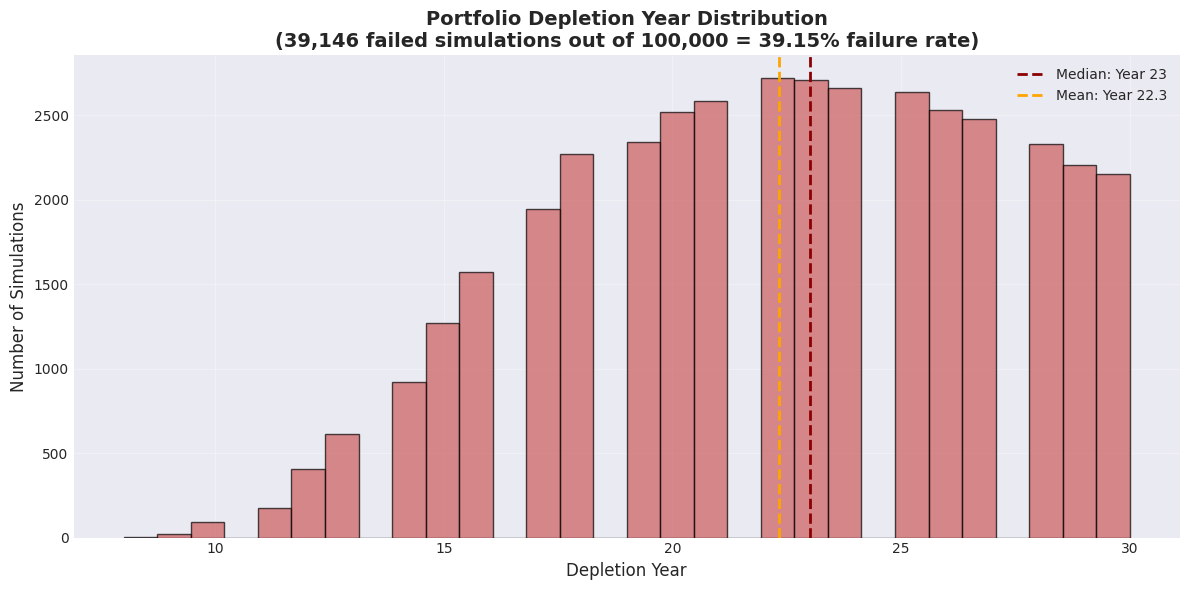


Basic Depletion Statistics:
  Total failures: 39,146 (39.15%)
  Median depletion year: 23
  Mean depletion year: 22.3


In [23]:
# ============================================================================
# DEPLETION YEAR ANALYSIS: Basic Distribution
# ============================================================================

# Calculate depletion years for all failed simulations
depletion_years = []
for portfolio in portfolios:
    if portfolio[-1] <= 0:
        depletion_year = np.where(portfolio <= 0)[0]
        if len(depletion_year) > 0:
            depletion_years.append(depletion_year[0])

if depletion_years:
    # Basic histogram of depletion years
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(depletion_years, bins=RETIREMENT_YEARS, edgecolor='black', alpha=0.7, color='indianred')
    ax.axvline(x=np.median(depletion_years), color='darkred', linestyle='--', linewidth=2, 
               label=f'Median: Year {np.median(depletion_years):.0f}')
    ax.axvline(x=np.mean(depletion_years), color='orange', linestyle='--', linewidth=2, 
               label=f'Mean: Year {np.mean(depletion_years):.1f}')
    ax.set_xlabel('Depletion Year', fontsize=12)
    ax.set_ylabel('Number of Simulations', fontsize=12)
    ax.set_title(
        f'Portfolio Depletion Year Distribution\n'
        f'({len(depletion_years):,} failed simulations out of {N_SIMULATIONS:,} = {len(depletion_years)/N_SIMULATIONS:.2%} failure rate)',
        fontsize=14, fontweight='bold'
    )
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nBasic Depletion Statistics:")
    print(f"  Total failures: {len(depletion_years):,} ({len(depletion_years)/N_SIMULATIONS:.2%})")
    print(f"  Median depletion year: {np.median(depletion_years):.0f}")
    print(f"  Mean depletion year: {np.mean(depletion_years):.1f}")
else:
    print("\n✓ No simulation resulted in portfolio depletion!")
    print("  All portfolios survived the full retirement period.")

DEPLETION YEAR PERCENTILES AND TIME-BAND ANALYSIS

--- Depletion Year Percentiles ---
  P5: Year 14.0
  P10: Year 16.0
  P25: Year 19.0
  P50: Year 23.0
  P75: Year 26.0
  P90: Year 29.0
  P95: Year 30.0

  Standard deviation: 4.77 years
  Min depletion year: 8
  Max depletion year: 30

--- Time-Band Distribution ---
  Early failures (years 1-10):     116 (  0.3%)
  Mid failures (years 11-20):   14,037 ( 35.9%)
  Late failures (years 21-30):  24,993 ( 63.8%)

--- Interpretation ---
  ✓ More late failures suggest the withdrawal rate is marginally sustainable.
    Most portfolios nearly made it through the full period.


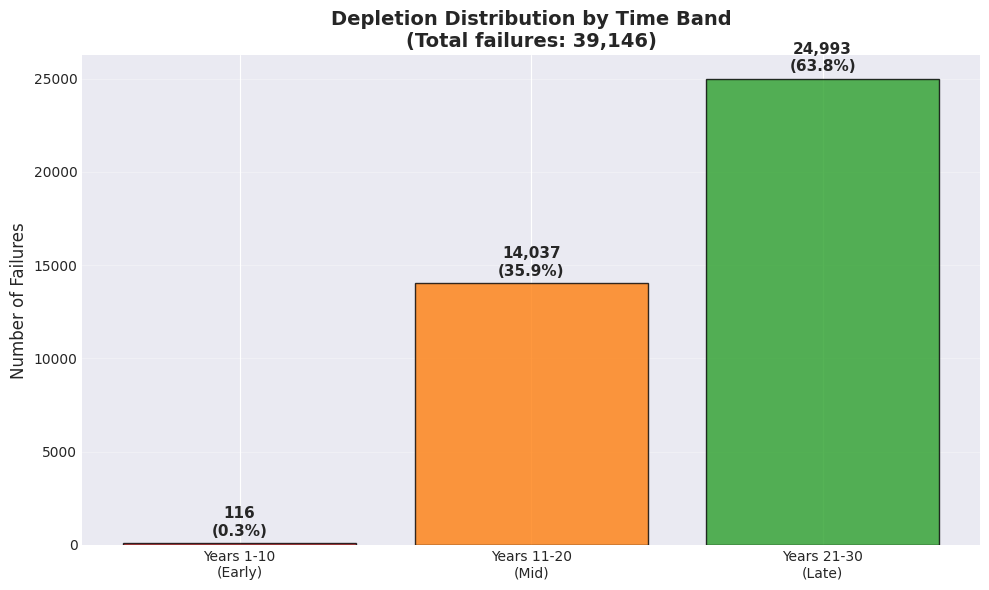

In [24]:
# ============================================================================
# DEPLETION YEAR ANALYSIS: Percentiles and Time-Band Distribution
# ============================================================================

if depletion_years:
    print("=" * 70)
    print("DEPLETION YEAR PERCENTILES AND TIME-BAND ANALYSIS")
    print("=" * 70)
    
    # Percentile analysis
    print("\n--- Depletion Year Percentiles ---")
    percentiles_to_calc = [5, 10, 25, 50, 75, 90, 95]
    for p in percentiles_to_calc:
        print(f"  P{p}: Year {np.percentile(depletion_years, p):.1f}")
    
    print(f"\n  Standard deviation: {np.std(depletion_years):.2f} years")
    print(f"  Min depletion year: {np.min(depletion_years)}")
    print(f"  Max depletion year: {np.max(depletion_years)}")
    
    # Time-band analysis: Early (1-10), Mid (11-20), Late (21-30)
    print("\n--- Time-Band Distribution ---")
    early_failures = sum(1 for y in depletion_years if y <= 10)
    mid_failures = sum(1 for y in depletion_years if 10 < y <= 20)
    late_failures = sum(1 for y in depletion_years if y > 20)
    
    print(f"  Early failures (years 1-10):  {early_failures:>6,} ({early_failures/len(depletion_years)*100:>5.1f}%)")
    print(f"  Mid failures (years 11-20):   {mid_failures:>6,} ({mid_failures/len(depletion_years)*100:>5.1f}%)")
    print(f"  Late failures (years 21-30):  {late_failures:>6,} ({late_failures/len(depletion_years)*100:>5.1f}%)")
    
    # Interpretation
    print("\n--- Interpretation ---")
    if early_failures > late_failures:
        print("  ⚠ More early failures suggest high sensitivity to sequence of returns risk.")
        print("    Poor market conditions in early retirement are most damaging.")
    elif late_failures > early_failures:
        print("  ✓ More late failures suggest the withdrawal rate is marginally sustainable.")
        print("    Most portfolios nearly made it through the full period.")
    else:
        print("  Failures are relatively evenly distributed across the retirement period.")
    
    # Visualize time-band distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bands = ['Years 1-10\n(Early)', 'Years 11-20\n(Mid)', 'Years 21-30\n(Late)']
    counts = [early_failures, mid_failures, late_failures]
    colors = ['#d62728', '#ff7f0e', '#2ca02c']  # Red, Orange, Green
    
    bars = ax.bar(bands, counts, color=colors, edgecolor='black', alpha=0.8)
    
    # Add percentage labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count:,}\n({count/len(depletion_years)*100:.1f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Number of Failures', fontsize=12)
    ax.set_title(f'Depletion Distribution by Time Band\n(Total failures: {len(depletion_years):,})', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 70)
else:
    print("No depletion events to analyze - all portfolios survived!")

HAZARD RATE ANALYSIS: Conditional Probability of Failure

Hazard rate = P(depletion in year t | survived to year t-1)
This measures the 'instantaneous' risk of failure at each point in time.

--- Hazard Rates at Key Years ---
  Year  1:  0.000% (  0.0 failures / 100,000.0 at risk)
  Year  5:  0.000% (  0.0 failures / 100,000.0 at risk)
  Year 10:  0.093% ( 93.0 failures / 99,977.0 at risk)
  Year 15:  1.298% (1,269.0 failures / 97,765.0 at risk)
  Year 20:  2.853% (2,521.0 failures / 88,368.0 at risk)
  Year 25:  3.504% (2,634.0 failures / 75,176.0 at risk)
  Year 30:  3.414% (2,151.0 failures / 63,005.0 at risk)

  Peak hazard year: 27 (3.538%)

--- Average Hazard Rate by Period ---
  Years 1-10:  0.012%
  Years 11-20: 1.499%
  Years 21-30: 3.382%


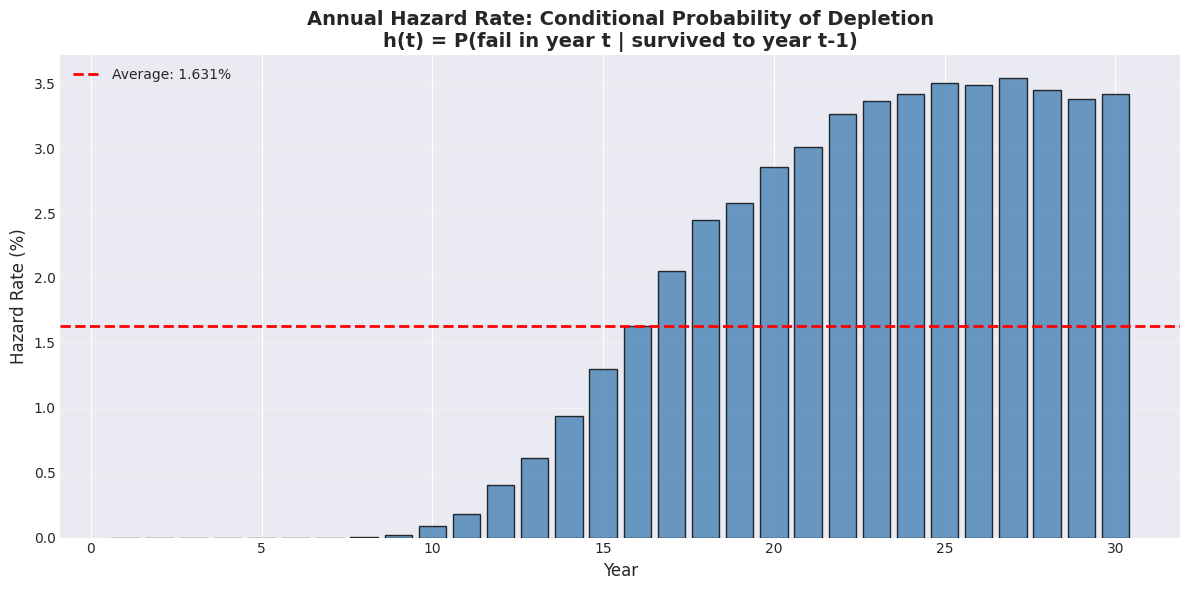

In [25]:
# ============================================================================
# HAZARD RATE ANALYSIS: Conditional Probability of Failure
# ============================================================================
# The hazard rate h(t) represents the probability of failing at time t,
# given that the portfolio survived until time t-1.
# Formula: h(t) = P(fail at t | survived to t-1) = failures_at_t / survived_to_t-1

print("=" * 70)
print("HAZARD RATE ANALYSIS: Conditional Probability of Failure")
print("=" * 70)
print("\nHazard rate = P(depletion in year t | survived to year t-1)")
print("This measures the 'instantaneous' risk of failure at each point in time.\n")

# Calculate hazard rates for each year
hazard_rates = []
years_survived = []
years_failed = []

for year in range(1, RETIREMENT_YEARS + 1):
    # Number of portfolios that survived to year-1 (still positive at end of year-1)
    survived_to_prev_year = np.sum(portfolios[:, year-1] > 0)
    
    # Number that failed exactly in year t (positive at t-1, zero/negative at t)
    failed_in_year = np.sum((portfolios[:, year-1] > 0) & (portfolios[:, year] <= 0))
    
    # Hazard rate
    hazard = failed_in_year / survived_to_prev_year if survived_to_prev_year > 0 else 0
    
    hazard_rates.append(hazard)
    years_survived.append(survived_to_prev_year)
    years_failed.append(failed_in_year)

# Create DataFrame for display
hazard_df = pd.DataFrame({
    'Year': range(1, RETIREMENT_YEARS + 1),
    'Survived_Start': years_survived,
    'Failed_This_Year': years_failed,
    'Hazard_Rate': hazard_rates
})

# Print summary for key years
print("--- Hazard Rates at Key Years ---")
key_years = [1, 5, 10, 15, 20, 25, 30]
for year in key_years:
    row = hazard_df[hazard_df['Year'] == year].iloc[0]
    print(f"  Year {year:>2}: {row['Hazard_Rate']*100:>6.3f}% "
          f"({row['Failed_This_Year']:>5,} failures / {row['Survived_Start']:>6,} at risk)")

# Find peak hazard year
peak_hazard_idx = np.argmax(hazard_rates)
peak_hazard_year = peak_hazard_idx + 1
print(f"\n  Peak hazard year: {peak_hazard_year} ({hazard_rates[peak_hazard_idx]*100:.3f}%)")

# Average hazard rate by period
avg_hazard_early = np.mean(hazard_rates[:10])
avg_hazard_mid = np.mean(hazard_rates[10:20])
avg_hazard_late = np.mean(hazard_rates[20:])

print(f"\n--- Average Hazard Rate by Period ---")
print(f"  Years 1-10:  {avg_hazard_early*100:.3f}%")
print(f"  Years 11-20: {avg_hazard_mid*100:.3f}%")
print(f"  Years 21-30: {avg_hazard_late*100:.3f}%")

# Plot hazard rate over time
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(range(1, RETIREMENT_YEARS + 1), np.array(hazard_rates) * 100, 
       color='steelblue', edgecolor='black', alpha=0.8)
ax.axhline(y=np.mean(hazard_rates) * 100, color='red', linestyle='--', linewidth=2,
           label=f'Average: {np.mean(hazard_rates)*100:.3f}%')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Hazard Rate (%)', fontsize=12)
ax.set_title('Annual Hazard Rate: Conditional Probability of Depletion\n'
             'h(t) = P(fail in year t | survived to year t-1)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(0, RETIREMENT_YEARS + 1, 5))

plt.tight_layout()
plt.show()

print("=" * 70)

PRE-DEPLETION PORTFOLIO VALUE ANALYSIS

This analysis examines portfolio values one year before depletion,
helping to identify warning signs and the speed of deterioration.

--- Pre-Depletion Portfolio Values (1 year before failure) ---
  Mean:   €      31,966 (3.2% of initial)
  Median: €      31,589 (3.2% of initial)
  Std:    €      18,835
  Min:    €           3
  Max:    €      95,294

  (For reference: initial annual withdrawal = €40,000)
  Median pre-depletion value = 0.8x annual withdrawal

--- Average Pre-Depletion Value by Time Band ---
  Early failures (yrs 1-10):  €      30,277 (n=116)
  Mid failures (yrs 11-20):   €      28,979 (n=14037)
  Late failures (yrs 21-30):  €      33,652 (n=24993)


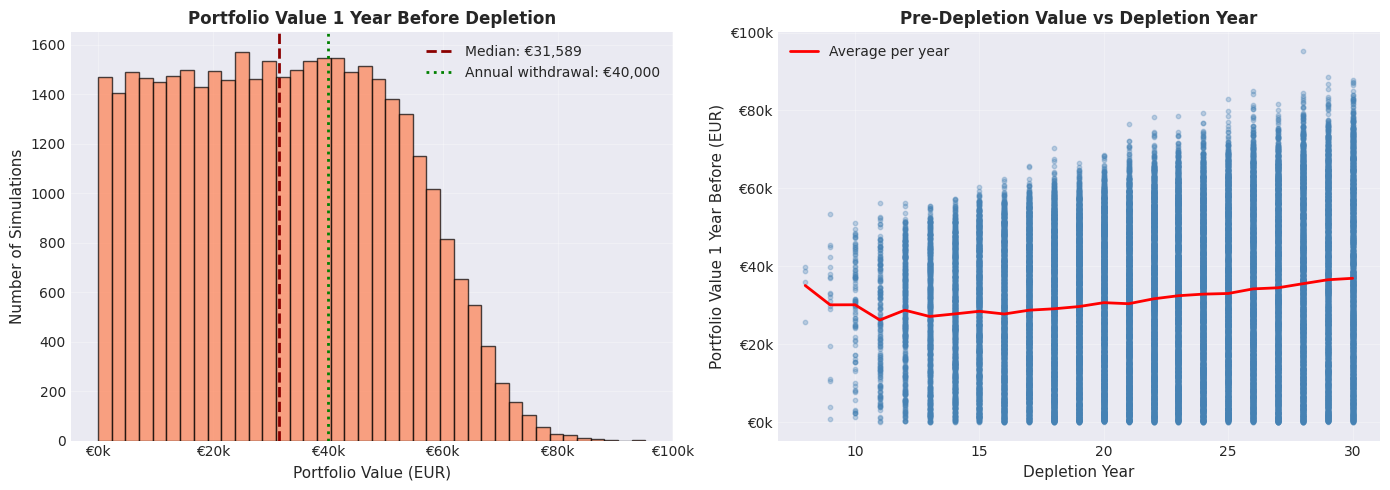

In [26]:
# ============================================================================
# PRE-DEPLETION PORTFOLIO VALUE ANALYSIS
# ============================================================================
# Analyze the portfolio value one year before depletion occurred.
# This helps understand how quickly portfolios deteriorate before failing.

if depletion_years:
    print("=" * 70)
    print("PRE-DEPLETION PORTFOLIO VALUE ANALYSIS")
    print("=" * 70)
    print("\nThis analysis examines portfolio values one year before depletion,")
    print("helping to identify warning signs and the speed of deterioration.\n")
    
    # Calculate portfolio value 1 year before depletion
    pre_depletion_values = []
    depletion_info = []
    
    for i, portfolio in enumerate(portfolios):
        if portfolio[-1] <= 0:
            dep_year = np.where(portfolio <= 0)[0]
            if len(dep_year) > 0:
                dep_yr = dep_year[0]
                if dep_yr > 0:
                    pre_val = portfolio[dep_yr - 1]
                    pre_depletion_values.append(pre_val)
                    depletion_info.append({
                        'sim_id': i,
                        'depletion_year': dep_yr,
                        'pre_depletion_value': pre_val,
                        'as_pct_initial': pre_val / INITIAL_PORTFOLIO * 100
                    })
    
    pre_depletion_df = pd.DataFrame(depletion_info)
    
    print("--- Pre-Depletion Portfolio Values (1 year before failure) ---")
    print(f"  Mean:   €{np.mean(pre_depletion_values):>12,.0f} ({np.mean(pre_depletion_values)/INITIAL_PORTFOLIO*100:.1f}% of initial)")
    print(f"  Median: €{np.median(pre_depletion_values):>12,.0f} ({np.median(pre_depletion_values)/INITIAL_PORTFOLIO*100:.1f}% of initial)")
    print(f"  Std:    €{np.std(pre_depletion_values):>12,.0f}")
    print(f"  Min:    €{np.min(pre_depletion_values):>12,.0f}")
    print(f"  Max:    €{np.max(pre_depletion_values):>12,.0f}")
    
    # Annual withdrawal for context
    first_year_withdrawal = INITIAL_PORTFOLIO * ANNUAL_WITHDRAWAL_RATE
    print(f"\n  (For reference: initial annual withdrawal = €{first_year_withdrawal:,.0f})")
    print(f"  Median pre-depletion value = {np.median(pre_depletion_values)/first_year_withdrawal:.1f}x annual withdrawal")
    
    # Distribution by depletion year
    print("\n--- Average Pre-Depletion Value by Time Band ---")
    early_pre = [row['pre_depletion_value'] for row in depletion_info if row['depletion_year'] <= 10]
    mid_pre = [row['pre_depletion_value'] for row in depletion_info if 10 < row['depletion_year'] <= 20]
    late_pre = [row['pre_depletion_value'] for row in depletion_info if row['depletion_year'] > 20]
    
    if early_pre:
        print(f"  Early failures (yrs 1-10):  €{np.mean(early_pre):>12,.0f} (n={len(early_pre)})")
    if mid_pre:
        print(f"  Mid failures (yrs 11-20):   €{np.mean(mid_pre):>12,.0f} (n={len(mid_pre)})")
    if late_pre:
        print(f"  Late failures (yrs 21-30):  €{np.mean(late_pre):>12,.0f} (n={len(late_pre)})")
    
    # Visualization: histogram of pre-depletion values
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Histogram of pre-depletion values
    ax1 = axes[0]
    ax1.hist(pre_depletion_values, bins=40, edgecolor='black', alpha=0.7, color='coral')
    ax1.axvline(x=np.median(pre_depletion_values), color='darkred', linestyle='--', linewidth=2,
                label=f'Median: €{np.median(pre_depletion_values):,.0f}')
    ax1.axvline(x=first_year_withdrawal, color='green', linestyle=':', linewidth=2,
                label=f'Annual withdrawal: €{first_year_withdrawal:,.0f}')
    ax1.set_xlabel('Portfolio Value (EUR)', fontsize=11)
    ax1.set_ylabel('Number of Simulations', fontsize=11)
    ax1.set_title('Portfolio Value 1 Year Before Depletion', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))
    
    # Right: Scatter plot of depletion year vs pre-depletion value
    ax2 = axes[1]
    ax2.scatter(pre_depletion_df['depletion_year'], pre_depletion_df['pre_depletion_value'],
                alpha=0.3, s=10, c='steelblue')
    
    # Add trend line (average per year)
    yearly_avg = pre_depletion_df.groupby('depletion_year')['pre_depletion_value'].mean()
    ax2.plot(yearly_avg.index, yearly_avg.values, 'r-', linewidth=2, label='Average per year')
    
    ax2.set_xlabel('Depletion Year', fontsize=11)
    ax2.set_ylabel('Portfolio Value 1 Year Before (EUR)', fontsize=11)
    ax2.set_title('Pre-Depletion Value vs Depletion Year', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 70)
else:
    print("No depletion events to analyze - all portfolios survived!")

SURVIVAL CURVE ANALYSIS

The survival curve shows the percentage of portfolios still solvent
at each point during the retirement period.



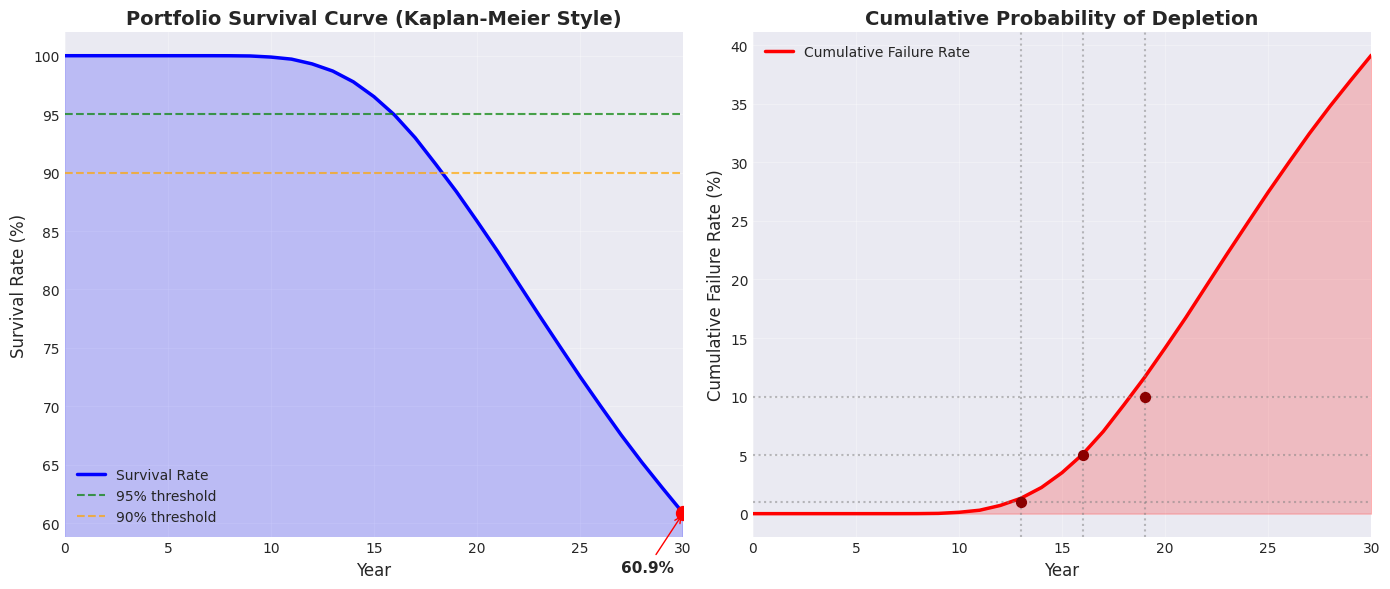

--- Survival Rate at Key Years ---
  Year  5: 100.00% survived (0.00% failed)
  Year 10:  99.88% survived (0.12% failed)
  Year 15:  96.50% survived (3.50% failed)
  Year 20:  85.85% survived (14.15% failed)
  Year 25:  72.54% survived (27.46% failed)
  Year 30:  60.85% survived (39.15% failed)

--- Years to Reach Failure Thresholds ---
  1% failure rate reached: Year 13
  5% failure rate reached: Year 16
  10% failure rate reached: Year 19


In [27]:
# ============================================================================
# SURVIVAL CURVE (Kaplan-Meier Style)
# ============================================================================
# The survival curve S(t) shows the probability that a portfolio is still
# "alive" (value > 0) at each point in time.

print("=" * 70)
print("SURVIVAL CURVE ANALYSIS")
print("=" * 70)
print("\nThe survival curve shows the percentage of portfolios still solvent")
print("at each point during the retirement period.\n")

# Calculate survival rate at each year
survival_rates = []
for year in range(RETIREMENT_YEARS + 1):
    n_survived = np.sum(portfolios[:, year] > 0)
    survival_rates.append(n_survived / N_SIMULATIONS)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Survival Curve
ax1 = axes[0]
years_plot = np.arange(0, RETIREMENT_YEARS + 1)

ax1.plot(years_plot, np.array(survival_rates) * 100, 'b-', linewidth=2.5, label='Survival Rate')
ax1.fill_between(years_plot, np.array(survival_rates) * 100, alpha=0.2, color='blue')

# Add reference lines
ax1.axhline(y=95, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='95% threshold')
ax1.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% threshold')

# Mark final survival rate
final_survival = survival_rates[-1] * 100
ax1.scatter([RETIREMENT_YEARS], [final_survival], color='red', s=100, zorder=5)
ax1.annotate(f'{final_survival:.1f}%', 
             xy=(RETIREMENT_YEARS, final_survival),
             xytext=(RETIREMENT_YEARS - 3, final_survival - 5),
             fontsize=11, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='red'))

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Survival Rate (%)', fontsize=12)
ax1.set_title('Portfolio Survival Curve (Kaplan-Meier Style)', fontsize=14, fontweight='bold')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, RETIREMENT_YEARS)
ax1.set_ylim(min(survival_rates) * 100 - 2, 102)
ax1.set_xticks(range(0, RETIREMENT_YEARS + 1, 5))

# Right: Failure Rate (cumulative probability of failure)
ax2 = axes[1]
failure_rates = [1 - sr for sr in survival_rates]

ax2.plot(years_plot, np.array(failure_rates) * 100, 'r-', linewidth=2.5, label='Cumulative Failure Rate')
ax2.fill_between(years_plot, np.array(failure_rates) * 100, alpha=0.2, color='red')

# Mark key points
for threshold in [1, 5, 10]:
    years_above = [y for y, fr in zip(years_plot, failure_rates) if fr * 100 >= threshold]
    if years_above:
        first_year = years_above[0]
        ax2.axhline(y=threshold, color='gray', linestyle=':', alpha=0.5)
        ax2.axvline(x=first_year, color='gray', linestyle=':', alpha=0.5)
        ax2.scatter([first_year], [threshold], color='darkred', s=50, zorder=5)

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Cumulative Failure Rate (%)', fontsize=12)
ax2.set_title('Cumulative Probability of Depletion', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, RETIREMENT_YEARS)
ax2.set_xticks(range(0, RETIREMENT_YEARS + 1, 5))

plt.tight_layout()
plt.show()

# Print key statistics
print("--- Survival Rate at Key Years ---")
key_years = [5, 10, 15, 20, 25, 30]
for year in key_years:
    sr = survival_rates[year] * 100
    print(f"  Year {year:>2}: {sr:>6.2f}% survived ({100-sr:.2f}% failed)")

# Find years when key thresholds are crossed
print("\n--- Years to Reach Failure Thresholds ---")
for threshold in [1, 5, 10]:
    years_above = [y for y, fr in zip(years_plot, failure_rates) if fr * 100 >= threshold]
    if years_above:
        print(f"  {threshold}% failure rate reached: Year {years_above[0]}")
    else:
        print(f"  {threshold}% failure rate: Not reached in {RETIREMENT_YEARS} years")

print("=" * 70)

DEPLETION YEAR CDF: Cumulative Distribution of Failures

The CDF shows what percentage of all failures occurred BY each year.
This helps answer: 'Of all portfolios that failed, what % failed by year X?'



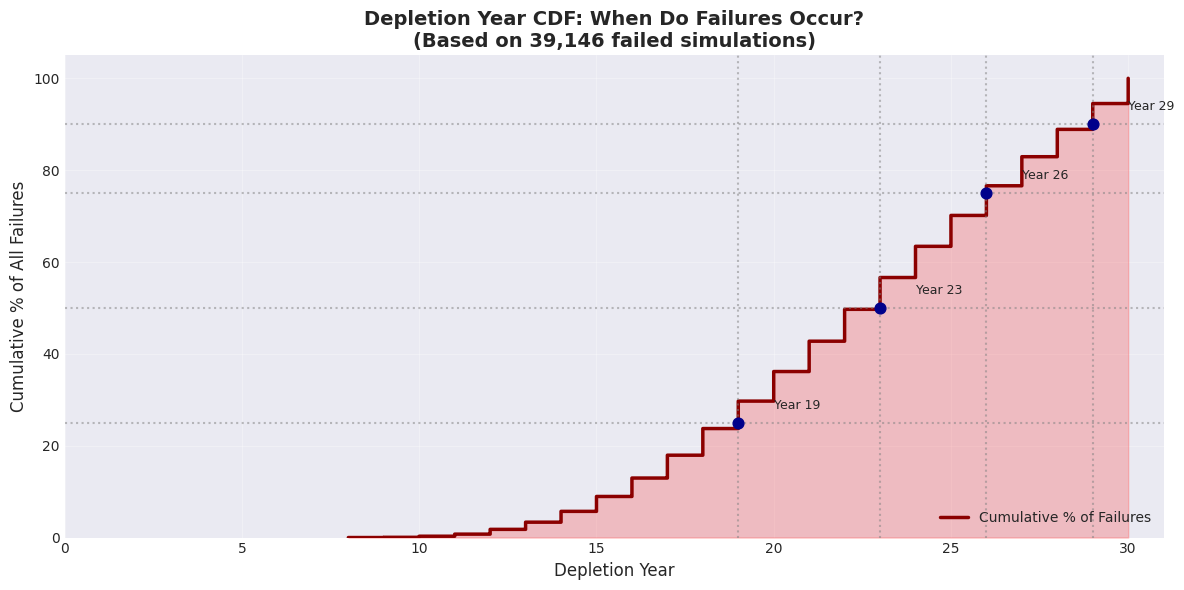

--- Percentiles of Depletion Year ---
  (Of all portfolios that failed, what % failed by year X?)

  10% of failures occurred by year 16
  25% of failures occurred by year 19
  50% of failures occurred by year 23
  75% of failures occurred by year 26
  90% of failures occurred by year 29
  95% of failures occurred by year 30

  Interquartile range (IQR): 7.0 years
  (Middle 50% of failures span 7.0 years)


In [28]:
# ============================================================================
# DEPLETION YEAR CDF (Cumulative Distribution Function)
# ============================================================================
# The CDF shows what percentage of failures occurred BY a given year.
# Useful for understanding the concentration of failures across time.

if depletion_years:
    print("=" * 70)
    print("DEPLETION YEAR CDF: Cumulative Distribution of Failures")
    print("=" * 70)
    print("\nThe CDF shows what percentage of all failures occurred BY each year.")
    print("This helps answer: 'Of all portfolios that failed, what % failed by year X?'\n")
    
    # Sort depletion years for CDF
    sorted_depletion = np.sort(depletion_years)
    n_failures = len(sorted_depletion)
    
    # Calculate CDF values
    cdf_values = np.arange(1, n_failures + 1) / n_failures
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot CDF
    ax.step(sorted_depletion, cdf_values * 100, where='post', linewidth=2.5, color='darkred',
            label='Cumulative % of Failures')
    ax.fill_between(sorted_depletion, cdf_values * 100, step='post', alpha=0.2, color='red')
    
    # Add reference lines at key percentiles
    for pct in [25, 50, 75, 90]:
        year_at_pct = np.percentile(depletion_years, pct)
        ax.axhline(y=pct, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=year_at_pct, color='gray', linestyle=':', alpha=0.5)
        ax.scatter([year_at_pct], [pct], color='darkblue', s=60, zorder=5)
        ax.annotate(f'Year {year_at_pct:.0f}', 
                    xy=(year_at_pct, pct),
                    xytext=(year_at_pct + 1, pct + 3),
                    fontsize=9)
    
    ax.set_xlabel('Depletion Year', fontsize=12)
    ax.set_ylabel('Cumulative % of All Failures', fontsize=12)
    ax.set_title('Depletion Year CDF: When Do Failures Occur?\n'
                 f'(Based on {n_failures:,} failed simulations)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, RETIREMENT_YEARS + 1)
    ax.set_ylim(0, 105)
    ax.set_xticks(range(0, RETIREMENT_YEARS + 1, 5))
    
    plt.tight_layout()
    plt.show()
    
    # Print key percentiles
    print("--- Percentiles of Depletion Year ---")
    print("  (Of all portfolios that failed, what % failed by year X?)")
    print()
    for pct in [10, 25, 50, 75, 90, 95]:
        year_at_pct = np.percentile(depletion_years, pct)
        print(f"  {pct}% of failures occurred by year {year_at_pct:.0f}")
    
    # Calculate interquartile range
    iqr = np.percentile(depletion_years, 75) - np.percentile(depletion_years, 25)
    print(f"\n  Interquartile range (IQR): {iqr:.1f} years")
    print(f"  (Middle 50% of failures span {iqr:.1f} years)")
    
    print("=" * 70)
else:
    print("No depletion events to analyze - all portfolios survived!")

PORTFOLIO VALUE DISTRIBUTION BY YEAR

Boxplots show the distribution of portfolio values at each milestone,
including median, quartiles, and outliers.



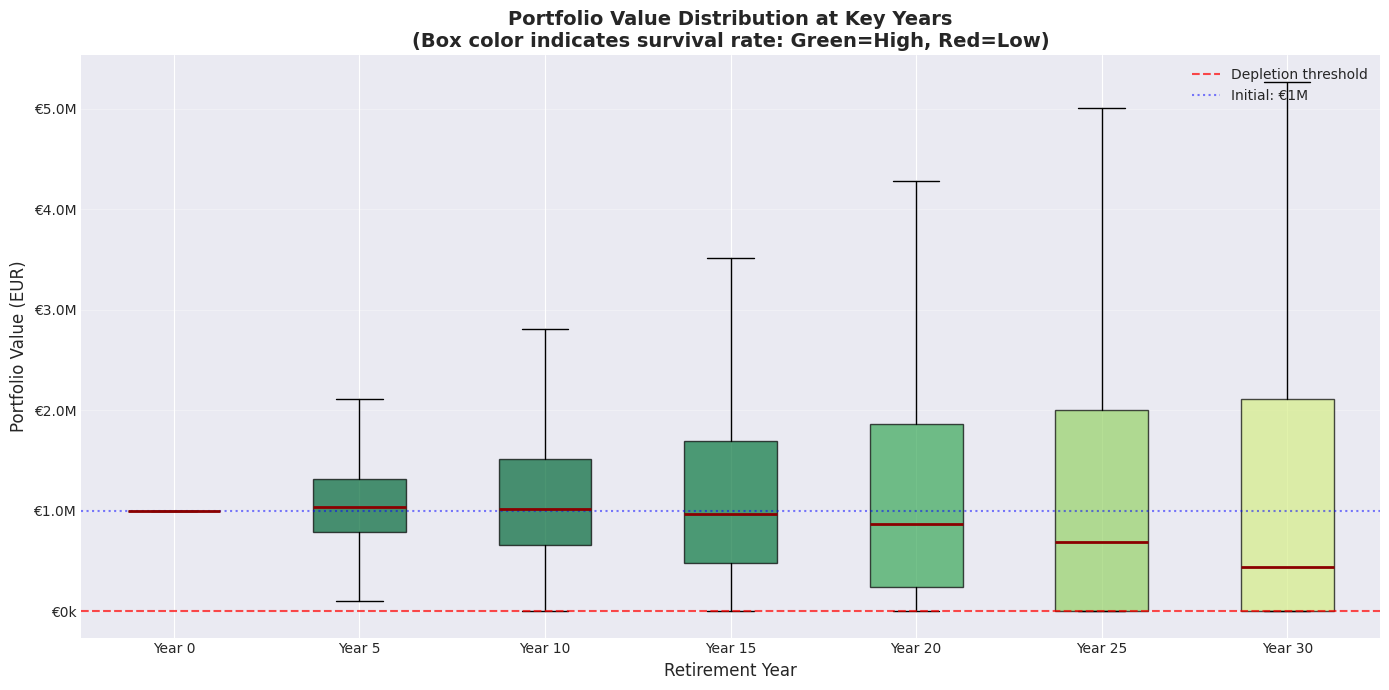

--- Summary Statistics by Year ---
Year         Median         Mean           P5          P95   Survival
----------------------------------------------------------------------
0      € 1,000,000 € 1,000,000 € 1,000,000 € 1,000,000     100.0%
5      € 1,035,531 € 1,078,845 €   509,718 € 1,795,210     100.0%
10     € 1,021,284 € 1,160,342 €   290,241 € 2,497,211      99.9%
15     €   970,890 € 1,241,520 €    52,541 € 3,324,513      96.5%
20     €   863,284 € 1,334,292 €         0 € 4,340,131      85.8%
25     €   688,602 € 1,475,065 €         0 € 5,621,165      72.5%
30     €   434,461 € 1,678,483 €         0 € 7,274,934      60.9%


In [29]:
# ============================================================================
# PORTFOLIO VALUE DISTRIBUTION BY YEAR (Boxplot)
# ============================================================================
# Boxplots show the distribution of portfolio values at key years,
# providing a comprehensive view of the spread and outliers.

print("=" * 70)
print("PORTFOLIO VALUE DISTRIBUTION BY YEAR")
print("=" * 70)
print("\nBoxplots show the distribution of portfolio values at each milestone,")
print("including median, quartiles, and outliers.\n")

# Select years for boxplot (every 5 years)
years_for_boxplot = [0, 5, 10, 15, 20, 25, 30]
data_for_boxplot = [portfolios[:, y] for y in years_for_boxplot]

# Create visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Create boxplot
bp = ax.boxplot(data_for_boxplot, tick_labels=[f'Year {y}' for y in years_for_boxplot],
                showfliers=False,  # Hide outliers for cleaner visualization
                patch_artist=True,
                medianprops=dict(color='darkred', linewidth=2))

# Color boxes by survival rate at that year
survival_at_years = [np.sum(portfolios[:, y] > 0) / N_SIMULATIONS for y in years_for_boxplot]
colors = plt.cm.RdYlGn(survival_at_years)  # Red-Yellow-Green colormap

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add zero line
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Depletion threshold')

# Add initial portfolio reference
ax.axhline(y=INITIAL_PORTFOLIO, color='blue', linestyle=':', linewidth=1.5, alpha=0.5, 
           label=f'Initial: €{INITIAL_PORTFOLIO/1e6:.0f}M')

ax.set_xlabel('Retirement Year', fontsize=12)
ax.set_ylabel('Portfolio Value (EUR)', fontsize=12)
ax.set_title('Portfolio Value Distribution at Key Years\n'
             '(Box color indicates survival rate: Green=High, Red=Low)',
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1e6:.1f}M' if x >= 1e6 else f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

# Print summary statistics for each year
print("--- Summary Statistics by Year ---")
print(f"{'Year':<6} {'Median':>12} {'Mean':>12} {'P5':>12} {'P95':>12} {'Survival':>10}")
print("-" * 70)

for year in years_for_boxplot:
    values = portfolios[:, year]
    survival = np.sum(values > 0) / N_SIMULATIONS * 100
    print(f"{year:<6} €{np.median(values):>10,.0f} €{np.mean(values):>10,.0f} "
          f"€{np.percentile(values, 5):>10,.0f} €{np.percentile(values, 95):>10,.0f} {survival:>9.1f}%")

print("=" * 70)

FAN CHART: Sample Portfolio Trajectories

This chart shows 200 randomly sampled portfolio trajectories.
Failed portfolios (depletion) are highlighted in red.



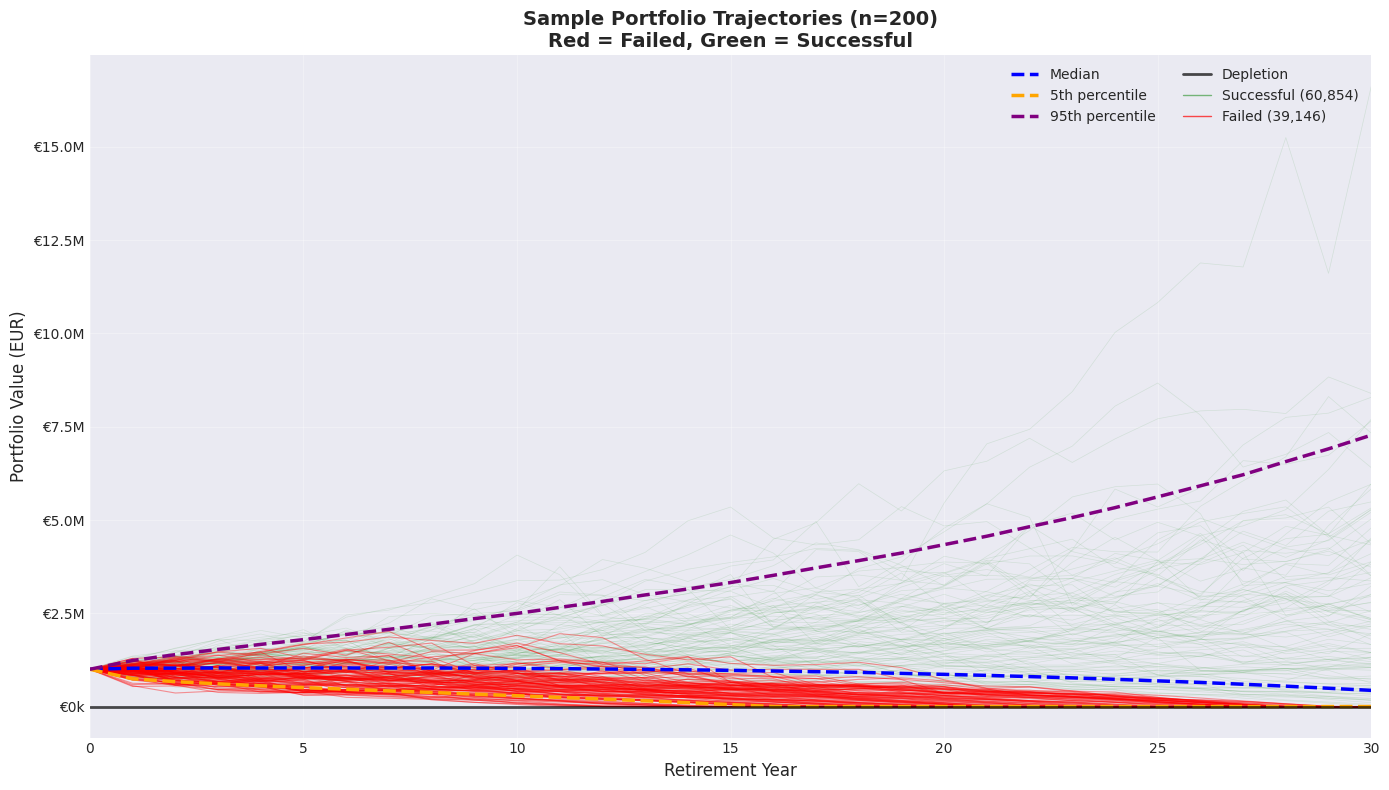

--- Extreme Scenarios ---

  Worst scenario (Sim #1):
    Final value: €0
    Depleted in year: 19

  Best scenario (Sim #45470):
    Final value: €84,299,201
    Growth multiple: 84.3x initial


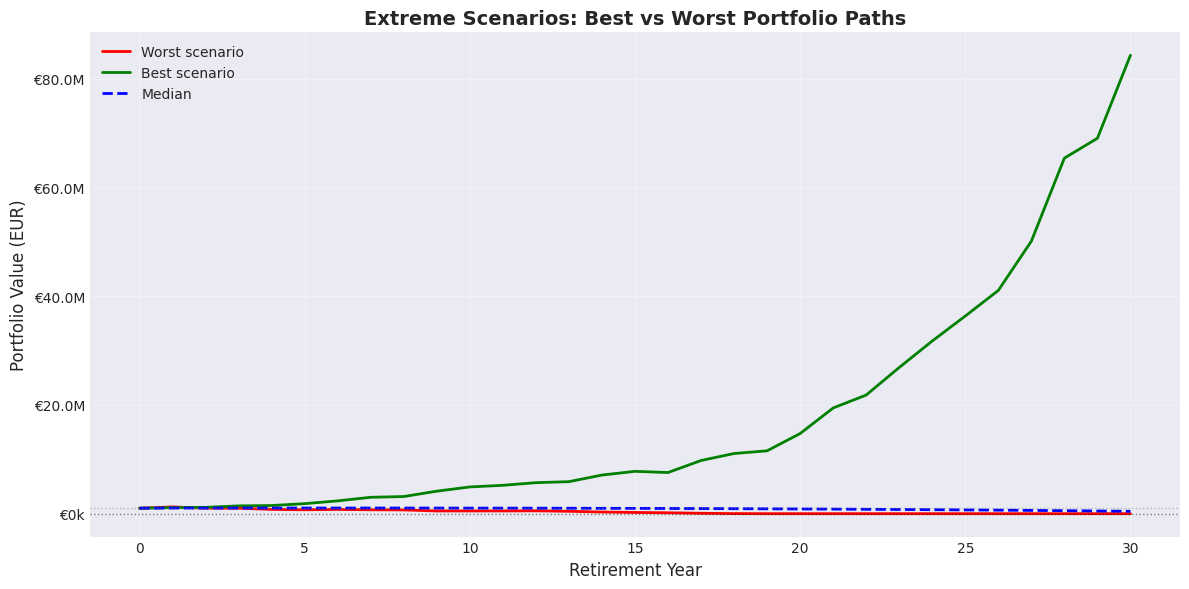

In [30]:
# ============================================================================
# FAN CHART: Sample Portfolio Trajectories
# ============================================================================
# Visualize individual portfolio paths to understand the variability
# and identify patterns in successful vs failed scenarios.

print("=" * 70)
print("FAN CHART: Sample Portfolio Trajectories")
print("=" * 70)
print("\nThis chart shows 200 randomly sampled portfolio trajectories.")
print("Failed portfolios (depletion) are highlighted in red.\n")

# Sample trajectories for visualization
np.random.seed(SEED)  # For reproducibility
n_sample = 200

# Separate failed and successful simulations
failed_mask = portfolios[:, -1] <= 0
failed_indices = np.where(failed_mask)[0]
success_indices = np.where(~failed_mask)[0]

# Sample proportionally (but ensure we get some failed ones if they exist)
n_failed_sample = min(len(failed_indices), n_sample // 2)
n_success_sample = n_sample - n_failed_sample

if len(failed_indices) > 0:
    sample_failed = np.random.choice(failed_indices, size=n_failed_sample, replace=False)
else:
    sample_failed = np.array([], dtype=int)
    
sample_success = np.random.choice(success_indices, size=min(n_success_sample, len(success_indices)), replace=False)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))

years_plot = np.arange(0, RETIREMENT_YEARS + 1)

# Plot successful trajectories first (green, low alpha)
for idx in sample_success:
    ax.plot(years_plot, portfolios[idx], color='green', alpha=0.1, linewidth=0.5)

# Plot failed trajectories (red, higher alpha)
for idx in sample_failed:
    ax.plot(years_plot, portfolios[idx], color='red', alpha=0.4, linewidth=0.8)

# Add percentile lines for reference
for p, color, label in [(50, 'blue', 'Median'), (5, 'orange', '5th percentile'), (95, 'purple', '95th percentile')]:
    pct_values = np.percentile(portfolios, p, axis=0)
    ax.plot(years_plot, pct_values, color=color, linewidth=2.5, label=label, linestyle='--')

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.7, label='Depletion')

# Add legend entries for trajectory types
ax.plot([], [], color='green', alpha=0.5, linewidth=1, label=f'Successful ({len(success_indices):,})')
ax.plot([], [], color='red', alpha=0.7, linewidth=1, label=f'Failed ({len(failed_indices):,})')

ax.set_xlabel('Retirement Year', fontsize=12)
ax.set_ylabel('Portfolio Value (EUR)', fontsize=12)
ax.set_title(f'Sample Portfolio Trajectories (n={n_sample})\n'
             f'Red = Failed, Green = Successful',
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, RETIREMENT_YEARS)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1e6:.1f}M' if abs(x) >= 1e6 else f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

# Additional analysis: worst and best performing portfolios
print("--- Extreme Scenarios ---")

# Worst performing (lowest final value)
worst_idx = np.argmin(portfolios[:, -1])
print(f"\n  Worst scenario (Sim #{worst_idx}):")
print(f"    Final value: €{portfolios[worst_idx, -1]:,.0f}")
if portfolios[worst_idx, -1] <= 0:
    dep_year = np.where(portfolios[worst_idx] <= 0)[0][0]
    print(f"    Depleted in year: {dep_year}")

# Best performing (highest final value)
best_idx = np.argmax(portfolios[:, -1])
print(f"\n  Best scenario (Sim #{best_idx}):")
print(f"    Final value: €{portfolios[best_idx, -1]:,.0f}")
print(f"    Growth multiple: {portfolios[best_idx, -1] / INITIAL_PORTFOLIO:.1f}x initial")

# Plot extreme scenarios
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(years_plot, portfolios[worst_idx], 'r-', linewidth=2, label='Worst scenario')
ax.plot(years_plot, portfolios[best_idx], 'g-', linewidth=2, label='Best scenario')
ax.plot(years_plot, np.median(portfolios, axis=0), 'b--', linewidth=2, label='Median')

ax.axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(y=INITIAL_PORTFOLIO, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Retirement Year', fontsize=12)
ax.set_ylabel('Portfolio Value (EUR)', fontsize=12)
ax.set_title('Extreme Scenarios: Best vs Worst Portfolio Paths', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1e6:.1f}M' if abs(x) >= 1e6 else f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

print("=" * 70)

---

## 13. Summary and Conclusions

Comprehensive summary of simulation results including:
- Portfolio configuration
- Historical data period used
- Success rate and percentile outcomes
- Failure statistics (if any)

### Key Takeaways
1. **Success Rate**: Indicates robustness of 4% withdrawal rate for this portfolio
2. **Percentiles**: Show range of possible outcomes
3. **Sensitivity**: Identifies maximum sustainable withdrawal rate
4. **Failures**: Understand downside risks and scenarios

### Important Caveat: No Tax Assumption
This analysis assumes **no capital gains tax** is applied on withdrawals. In practice:
- Italian investors face a 26% capital gains tax on financial gains
- This would reduce the effective withdrawal rate or require higher gross withdrawals
- Tax-advantaged accounts (where available) would more closely match these results

In [31]:
print("=" * 70)
print("MONTE CARLO SIMULATION SUMMARY (BLOCK BOOTSTRAP)")
print("=" * 70)
print(f"Simulation parameters:")
print(f"  - Initial portfolio: €{INITIAL_PORTFOLIO:,}")
print(f"  - Withdrawal rate: {ANNUAL_WITHDRAWAL_RATE:.1%}")
print(f"  - Retirement duration: {RETIREMENT_YEARS} years")
print(f"  - Number of simulations: {N_SIMULATIONS:,}")
print(f"  - Block size: {BLOCK_SIZE_MONTHS} months")
print(f"  - Capital gains tax: None (tax-free withdrawals)")
print(f"\nPortfolio composition:")
for asset, weight in PORTFOLIO_WEIGHTS.items():
    print(f"  - {asset}: {weight:.1%}")
print(f"\nInflation series: {INFLATION_SERIES}")
print(f"\nHistorical data period:")
print(f"  - From: {returns_df['date'].min()}")
print(f"  - To: {returns_df['date'].max()}")
print(f"  - Total days: {len(returns_df):,}")
print(f"\nResults:")
print(f"  - Success rate: {success_rate:.2%}")
print(f"  - Median final value: €{np.median(portfolios[:, -1]):,.0f}")
print(f"  - P5 final value: €{np.percentile(portfolios[:, -1], 5):,.0f}")
print(f"  - P95 final value: €{np.percentile(portfolios[:, -1], 95):,.0f}")
if depletion_years:
    print(f"  - Failed simulations: {len(depletion_years)} ({len(depletion_years)/N_SIMULATIONS:.1%})")
    print(f"  - Median depletion year: {np.median(depletion_years):.0f}")
print("=" * 70)
print("\n⚠️  NOTE: This simulation assumes NO capital gains tax on withdrawals.")
print("    In taxed scenarios, effective withdrawal rates would be lower.")

MONTE CARLO SIMULATION SUMMARY (BLOCK BOOTSTRAP)
Simulation parameters:
  - Initial portfolio: €1,000,000
  - Withdrawal rate: 4.0%
  - Retirement duration: 30 years
  - Number of simulations: 100,000
  - Block size: 6 months
  - Capital gains tax: None (tax-free withdrawals)

Portfolio composition:
  - MSCI_EUROPE: 90.0%
  - BUND_10Y: 10.0%

Inflation series: HICP_EU

Historical data period:
  - From: 2000-12-30 00:00:00
  - To: 2025-10-31 00:00:00
  - Total days: 9,072

Results:
  - Success rate: 60.85%
  - Median final value: €434,461
  - P5 final value: €0
  - P95 final value: €7,274,934
  - Failed simulations: 39146 (39.1%)
  - Median depletion year: 23

⚠️  NOTE: This simulation assumes NO capital gains tax on withdrawals.
    In taxed scenarios, effective withdrawal rates would be lower.
